**1. Adım: Problem Tanımı**

Kredi başvurularının hızlı ve doğru bir şekilde değerlendirilebilmesi için otomatik bir kredi skorlama modeli geliştirmeyi hedefliyoruz. Bu model, müşterilerin finansal geçmişine ve diğer özelliklerine dayanarak kredi onayı verip vermeyeceğini tahmin edecek.

**2. Adım: Veri Toplama**

Bu projede kullanılan veri seti, Kaggle'dan alınmıştır. Veriler, müşterilerin finansal bilgilerini ve kredi ödeme davranışlarını içermektedir. Veri seti linki: [https://www.kaggle.com/datasets/parisrohan/credit-score-classification](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fparisrohan%2Fcredit-score-classification)

**3. Adım: Veri Ön İşleme**

Veri ön işleme, eksik verilerin doldurulması, sayısal olmayan verilerin temizlenmesi, aykırı değerlerin giderilmesi ve kategorik verilerin sayısallaştırılması gibi işlemleri içerir.

**3.1 Veri Okuma**

In [1]:
import pandas as pd

# Veri setini CSV dosyasından okuyoruz.
# DataFrame oluşturuluyor.
data = pd.read_csv("/content/NoLimitData.csv")

# Veri türlerini kontrol etmek için `dtypes` kullanıyoruz.
# Bu işlem, her sütunun veri tipini listeler (örneğin: int64, float64, object).
print("Veri türleri:")
print(data.dtypes)

# Veri setinin ilk 5 satırını görüntülüyoruz.
print("\nVerinin ilk 5 satırı:")
print(data.head())

#`Customer_ID` sütununda birden fazla kez geçen değerlerin sayısını buluyoruz.
# Müşteri kayıtlarının benzersiz olup olmadığını kontroletmek için önemlidir.
duplicate_customers = data['Customer_ID'].duplicated().sum()
print(f"\nAynı Customer_ID'ye sahip kayıt sayısı: {duplicate_customers}")

# Eğer tekrarlanan müşteri kimlikleri varsa uyarı veriyoruz.
if duplicate_customers > 0:
    print("Uyarı: Aynı Customer_ID'ye sahip birden fazla kayıt var!")

# Her müşteri için benzersiz (tekil) bir kayıt olup olmadığını kontrol ediyoruz.
# Bunun için `ID` sütunundaki toplam satır sayısını ve benzersiz değerlerin sayısını karşılaştırıyoruz.
unique_customer_check = len(data['ID']) == len(data['ID'].unique())
if not unique_customer_check:
    print("Hata: Her bir satırdan birden fazla var.")
else:
    print("Tekrarlayan satır yok. Sıkıntı yok");

# Veri setindeki eksik değerleri sütun bazında sayıyoruz.
# Her sütun için eksik veri miktarını gösteriyoruz.
missing_values = data.isnull().sum()
print("\nEksik veri sayısı (sütun bazında):")
print(missing_values)

# Eksik veri oranını yüzdelik olarak hesaplıyoruz.
missing_percentage = (missing_values / len(data)) * 100
print("\nEksik veri yüzdeleri (sütun bazında):")
print(missing_percentage)

# Eksik veri oranı %20'den fazla olan sütunları tespit ediyoruz.
threshold = 20  # %20 eksik veri sınırı
columns_with_many_missing = missing_percentage[missing_percentage > threshold].index.tolist()

# Eğer %20'den fazla eksik veri içeren sütunlar varsa bunları listeliyoruz.
if columns_with_many_missing:
    print(f"\nEksik veri oranı %20'yi geçen sütunlar: {columns_with_many_missing}")
else:
    print("\nEksik veri oranı %20'yi geçen sütun yok.")


Veri türleri:
ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
dtype: object


**3.2 Eksik ve hatalı değerlerin temizlenmesi**

In [2]:
import pandas as pd
import numpy as np

# Eksik ve hatalı değerlerin temizlenmesi için genel bir fonksiyon tanımlıyoruz.
# Bu fonksiyon, verilen sütundaki eksik verileri, hatalı değerleri ve sınırların dışındaki değerleri temizler.
def clean_column(data, column, lower_limit=None, upper_limit=None, replace_na_method='median'):
    """
    Belirtilen sütundaki eksik ve hatalı değerleri temizler.
    - `lower_limit` ve `upper_limit`: Değerlerin alt ve üst sınırlarını belirler.
    - `replace_na_method`: Eksik verileri doldurma yöntemi (median, mean, mode).
    """
    # Sütundaki hatalı karakterleri temizliyoruz (örneğin, '_').
    data[column] = data[column].astype(str).str.replace('_', '', regex=True)

    # String olarak belirtilmiş "nan" ifadelerini gerçek NaN değerlerine dönüştürüyoruz.
    data[column] = data[column].replace(['nan', 'NaN'], np.nan)

    # Sütunu sayısal türe dönüştürüyoruz. Dönüştürülemeyen değerler NaN yapılır.
    data[column] = pd.to_numeric(data[column], errors='coerce')

    # Alt ve üst sınırları uygula (belirtilmişse).
    if lower_limit is not None:
        data.loc[data[column] < lower_limit, column] = np.nan
    if upper_limit is not None:
        data.loc[data[column] > upper_limit, column] = np.nan

    # Eksik değerleri belirli bir yönteme göre dolduruyoruz (median, mean, mode).
    if replace_na_method == 'median':
        data[column] = data[column].fillna(data[column].median())
    elif replace_na_method == 'mean':
        data[column] = data[column].fillna(data[column].mean())
    elif replace_na_method == 'mode':
        data[column] = data[column].fillna(data[column].mode()[0])

    # Temizlenmiş sütunu geri döndür.
    return data


# Hatalı ve eksik verilerin temizleneceği sütunlar ve bu sütunlar için sınırlar ve doldurma yöntemleri.
columns_to_clean = {
    'Amount_invested_monthly': {'replace_na_method': 'mean'},  # Ortalama ile doldur.
    'Monthly_Balance': {'lower_limit': -10000, 'upper_limit': 100000, 'replace_na_method': 'median'},
    'Age': {'lower_limit': 18, 'upper_limit': 100, 'replace_na_method': 'median'},
    'Num_of_Delayed_Payment': {'upper_limit': 60, 'replace_na_method': 'median'},
    'Outstanding_Debt': {'lower_limit': 0, 'upper_limit': 500000, 'replace_na_method': 'median'},
    'Annual_Income': {'lower_limit': 0, 'upper_limit': 1000000, 'replace_na_method': 'median'},
    'Num_of_Loan': {'upper_limit': 10, 'replace_na_method': 'median'},
    'Changed_Credit_Limit': {'lower_limit': -10000, 'upper_limit': 100000, 'replace_na_method': 'median'},
    'Monthly_Inhand_Salary': {'lower_limit': 0, 'upper_limit': 100000, 'replace_na_method': 'median'}
}

# Belirtilen sütunlar için temizleme işlemini uyguluyoruz.
for column, params in columns_to_clean.items():
    data = clean_column(
        data,
        column,
        lower_limit=params.get('lower_limit'),
        upper_limit=params.get('upper_limit'),
        replace_na_method=params.get('replace_na_method')
    )

# 'Occupation' sütununda hatalı `_` karakterlerini boşlukla değiştiriyoruz.
if 'Occupation' in data.columns:
    data['Occupation'] = data['Occupation'].astype(str).str.replace('_', ' ')  # Veri türünü string olarak ayarlıyoruz.

# Her sütun için temizleme sonrası temel istatistikleri görüntülüyoruz.
for column in columns_to_clean.keys():
    print(f"{column} sütununun güncellenmiş temel istatistikleri:")
    print(data[column].describe())  # İstatistiksel özet (örneğin, ortalama, min, max).
    print(f"{column} sütunundaki eksik veri sayısı: {data[column].isnull().sum()}")  # Eksik veri sayısı.

Amount_invested_monthly sütununun güncellenmiş temel istatistikleri:
count    50000.000000
mean       641.654795
std       2006.708477
min          0.000000
25%         77.031011
50%        143.245476
75%        305.878898
max      10000.000000
Name: Amount_invested_monthly, dtype: float64
Amount_invested_monthly sütunundaki eksik veri sayısı: 0
Monthly_Balance sütununun güncellenmiş temel istatistikleri:
count    50000.000000
mean       402.315569
std        212.583269
min          0.103402
25%        271.118562
50%        336.984582
75%        468.571215
max       1606.518192
Name: Monthly_Balance, dtype: float64
Monthly_Balance sütunundaki eksik veri sayısı: 0
Age sütununun güncellenmiş temel istatistikleri:
count    50000.000000
mean        34.740640
std          9.787174
min         18.000000
25%         27.000000
50%         34.000000
75%         42.000000
max         95.000000
Name: Age, dtype: float64
Age sütunundaki eksik veri sayısı: 0
Num_of_Delayed_Payment sütununun güncell

**3.3 Aykırı Değerleri Tespit Etme ve Temizleme**

In [3]:
import pandas as pd
import numpy as np
import re

# Eksik değerleri doldurma ve Credit_History_Age'i toplam ay sayısına çevirme
def process_credit_history_age(data):
    if 'Credit_History_Age' in data.columns:
        # Eksik değerleri doldur
        data['Credit_History_Age'] = data['Credit_History_Age'].fillna(data['Credit_History_Age'].mode()[0])

        # Formatı kontrol et ve dönüştür
        def convert_credit_history_age(text):
            pattern = r'(\d+)\s*Years?\s*and\s*(\d+)\s*Months?'
            match = re.match(pattern, str(text))
            if match:
                years = int(match.group(1))
                months = int(match.group(2))
                return years * 12 + months
            return np.nan

        data['Credit_History_Age_in_months'] = data['Credit_History_Age'].apply(convert_credit_history_age)
        # Eksik değerleri medyan ile doldur
        data['Credit_History_Age_in_months'] = data['Credit_History_Age_in_months'].fillna(data['Credit_History_Age_in_months'].median())
    else:
        print("'Credit_History_Age' sütunu veri setinde bulunamadı.")
    return data

# Aykırı değerleri temizleme
def clean_and_remove_outliers(data, columns, strict=True):
    """
    Aykırı değerleri temizler.
    strict: True olduğunda daha dar sınırlar kullanır.
    """
    for col in columns:
        if col in data.columns:
            # Sayısal olmayan değerleri NaN olarak işaretle
            data[col] = pd.to_numeric(data[col], errors='coerce')
            # Negatif değerleri 0 yap (örneğin hesap sayısı gibi sütunlarda)
            if col in ['Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries']:
                data[col] = data[col].clip(lower=0)

            # Aykırı değer sınırlarını hesapla
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - (1.5 * IQR if strict else 3 * IQR)
            upper_bound = Q3 + (1.5 * IQR if strict else 3 * IQR)

            # Aykırı değerleri temizle
            data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
        else:
            print(f"'{col}' sütunu veri setinde bulunamadı.")
    return data



# Veri işleme
def preprocess_data(data):
    # İşlenecek sütunlar
    columns_with_no_negative = [
        'Num_Bank_Accounts', 'Num_Credit_Card', 'Num_of_Delayed_Payment',
        'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age_in_months',
        'Monthly_Inhand_Salary', 'Monthly_Balance', 'Amount_invested_monthly',
        'Total_EMI_per_month', 'Delay_from_due_date'
    ]

    # Credit_History_Age sütununu işle
    data = process_credit_history_age(data)

    # Aykırı değerleri temizle
    data = clean_and_remove_outliers(data, columns_with_no_negative, strict=True)

    # Eksik değerleri doldur
    if 'Num_Credit_Inquiries' in data.columns:
        if data['Num_Credit_Inquiries'].isnull().sum() > 0:
            data['Num_Credit_Inquiries'] = data['Num_Credit_Inquiries'].fillna(data['Num_Credit_Inquiries'].median())

    return data

# Veri setini işleme
data = preprocess_data(data)

#Credit_History_Age silinmesi
data.drop('Credit_History_Age', axis=1,inplace=True)
print(data.columns)

# Temizleme sonrası kontrol
print("Temizleme sonrası veri setinin özet istatistikleri:")
print(data.describe())
# Sonuçları kontrol et
if 'Credit_History_Age_in_months' in data.columns:
    print("Credit_History_Age_in_months eksik veri sayısı:", data['Credit_History_Age_in_months'].isnull().sum())
    print("Credit_History_Age_in_months sütununun temel istatistikleri:")
    print(data['Credit_History_Age_in_months'].describe())

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
print("Aykırı değer temizliği sonrası veri setinin özet istatistikleri:")
print(data[numeric_columns].describe())


Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_History_Age_in_months'],
      dtype='object')
Temizleme sonrası veri setinin özet istatistikleri:
                Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  50000.000000   50000.000000           50000.000000       50000.000000   
mean      34.740640   50554.019174            3942.991306           5.464680   
std        9.787174   39879.021559            2742.343721           2.715964   
min       18.000000    7005.930000             

**3.4 Kategorik değişkenleri kodlama (One Hot Encoding)**

In [4]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 'Type_of_Loan' sütununu kontrol et ve işle
if 'Type_of_Loan' in data.columns:
    # Eksik değerleri 'Unknown' ile doldur ve kredi türlerini listeye dönüştür
    data['Type_of_Loan'] = data['Type_of_Loan'].fillna('Unknown')
    data['Type_of_Loan_List'] = data['Type_of_Loan'].str.split(', ')

    # Çoklu kredi türlerini ayrı sütunlara dönüştürme
    mlb = MultiLabelBinarizer()
    loan_types_encoded = mlb.fit_transform(data['Type_of_Loan_List'])
    loan_type_columns = ['Loan_Type_' + loan_type.replace(' ', '_') for loan_type in mlb.classes_]
    loan_type_df = pd.DataFrame(loan_types_encoded, columns=loan_type_columns, index=data.index)

    # Yeni sütunları veri setine ekle ve gereksiz ara sütunları kaldır
    data = pd.concat([data, loan_type_df], axis=1)
    data.drop(['Type_of_Loan', 'Type_of_Loan_List'], axis=1, inplace=True)

# Veri setindeki mevcut kategorik sütunları otomatik algıla
categorical_columns = [col for col in ['Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount', 'Occupation'] if col in data.columns]

# 'Occupation' sütununda nadir kategorileri 'Other' olarak gruplandır
if 'Occupation' in categorical_columns:
    occupation_counts = data['Occupation'].value_counts()
    rare_categories = occupation_counts[occupation_counts < 500].index  # 500'den az gözleme sahip kategoriler
    data['Occupation'] = data['Occupation'].replace(rare_categories, 'Other')

# Kategorik sütunları One-Hot Encoding ile işleme
if categorical_columns:
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Gereksiz sütunları kaldırma (kimlik ve fazla ayrıntı içeren sütunlar)
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True, errors='ignore')

# Boolean tipindeki sütunları 1 ve 0 formatına çevirme
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)

# Kodlama sonrası kontrol
print("Kodlama sonrası veri setinin sütun sayısı:", data.shape[1])
print("Kodlama sonrası veri setinin ilk 5 satırı:")
print(data.head())

Kodlama sonrası veri setinin sütun sayısı: 62
Kodlama sonrası veri setinin ilk 5 satırı:
    Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  23.0       19114.12            1824.843333                  3   
1  24.0       19114.12            1824.843333                  3   
2  24.0       19114.12            1824.843333                  3   
3  24.0       19114.12            3086.305000                  3   
4  28.0       34847.84            3037.986667                  2   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0              4.0              3          4.0                    3   
1              4.0              3          4.0                    3   
2              4.0              3          4.0                   -1   
3              4.0              3          4.0                    4   
4              4.0              6          1.0                    3   

   Num_of_Delayed_Payment  Changed_Credit_Limit  ...  Occupation_Entreprene

**3.5 Sayısal değişkenleri ölçeklendirme**

In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Sayısal sütunları belirliyoruz
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Min-Max Scaler tanımlıyoruz
scaler = MinMaxScaler()

# Sayısal sütunları ölçeklendirme işlemi
try:
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
    print(f"Başarıyla {len(numeric_columns)} sayısal sütun ölçeklendirildi.")
except Exception as e:
    print("Ölçeklendirme sırasında bir hata oluştu:", e)

# Kontrol için ilk 5 satırı yazdırıyoruz
print("\nÖlçeklendirilmiş verinin ilk 5 satırı:")
print(data[numeric_columns].head())

# Ölçeklendirilmiş sütunların özet istatistiklerini kontrol ediyoruz
print("\nÖlçeklendirilmiş sayısal sütunların özet istatistikleri:")
print(data[numeric_columns].describe())



Başarıyla 62 sayısal sütun ölçeklendirildi.

Ölçeklendirilmiş verinin ilk 5 satırı:
        Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  0.064935       0.012306               0.146943           0.230769   
1  0.077922       0.012306               0.146943           0.230769   
2  0.077922       0.012306               0.146943           0.230769   
3  0.077922       0.012306               0.268796           0.230769   
4  0.129870       0.028296               0.264128           0.153846   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0         0.347826       0.000345     0.954128             0.133333   
1         0.347826       0.000345     0.954128             0.133333   
2         0.347826       0.000345     0.954128             0.066667   
3         0.347826       0.000345     0.954128             0.150000   
4         0.347826       0.000862     0.926606             0.133333   

   Num_of_Delayed_Payment  Changed_Credit_Limit  ...  Oc

**3.6 Gereksiz kolonların çıkarılması**

In [6]:
# 'Loan' ile başlayan kolonları seç, bir tanesini hariç tut
exclude_column = 'Loan_Type_Personal_Loan'  # Hariç tutmak istediğiniz kolon
columns_to_drop = [col for col in data.columns if col.lower().startswith('loan') and col != exclude_column]

# Belirlenen kolonları kalıcı olarak veri setinden çıkar
data.drop(columns=columns_to_drop, inplace=True)

# Silinen kolonları kontrol et
print(f"Silinen Kolonlar (Hariç Tutulan: {exclude_column}): {columns_to_drop}")
print(f"Yeni veri seti boyutu: {data.shape}")

Silinen Kolonlar (Hariç Tutulan: Loan_Type_Personal_Loan): ['Loan_Type_Auto_Loan', 'Loan_Type_Credit-Builder_Loan', 'Loan_Type_Debt_Consolidation_Loan', 'Loan_Type_Home_Equity_Loan', 'Loan_Type_Mortgage_Loan', 'Loan_Type_Not_Specified', 'Loan_Type_Payday_Loan', 'Loan_Type_Student_Loan', 'Loan_Type_Unknown', 'Loan_Type_and_Auto_Loan', 'Loan_Type_and_Credit-Builder_Loan', 'Loan_Type_and_Debt_Consolidation_Loan', 'Loan_Type_and_Home_Equity_Loan', 'Loan_Type_and_Mortgage_Loan', 'Loan_Type_and_Not_Specified', 'Loan_Type_and_Payday_Loan', 'Loan_Type_and_Personal_Loan', 'Loan_Type_and_Student_Loan']
Yeni veri seti boyutu: (50000, 44)


**4.Adım: Keşifsel Veri Analizi**

Keşifsel veri analizi (EDA), veri setindeki temel istatistiksel özellikleri ve dağılımları anlamak, veri setindeki ilişkileri ortaya çıkarmak ve anormallikleri tespit etmek için gerçekleştirilir

**4.1 Histogramlar ve dağılımlar**

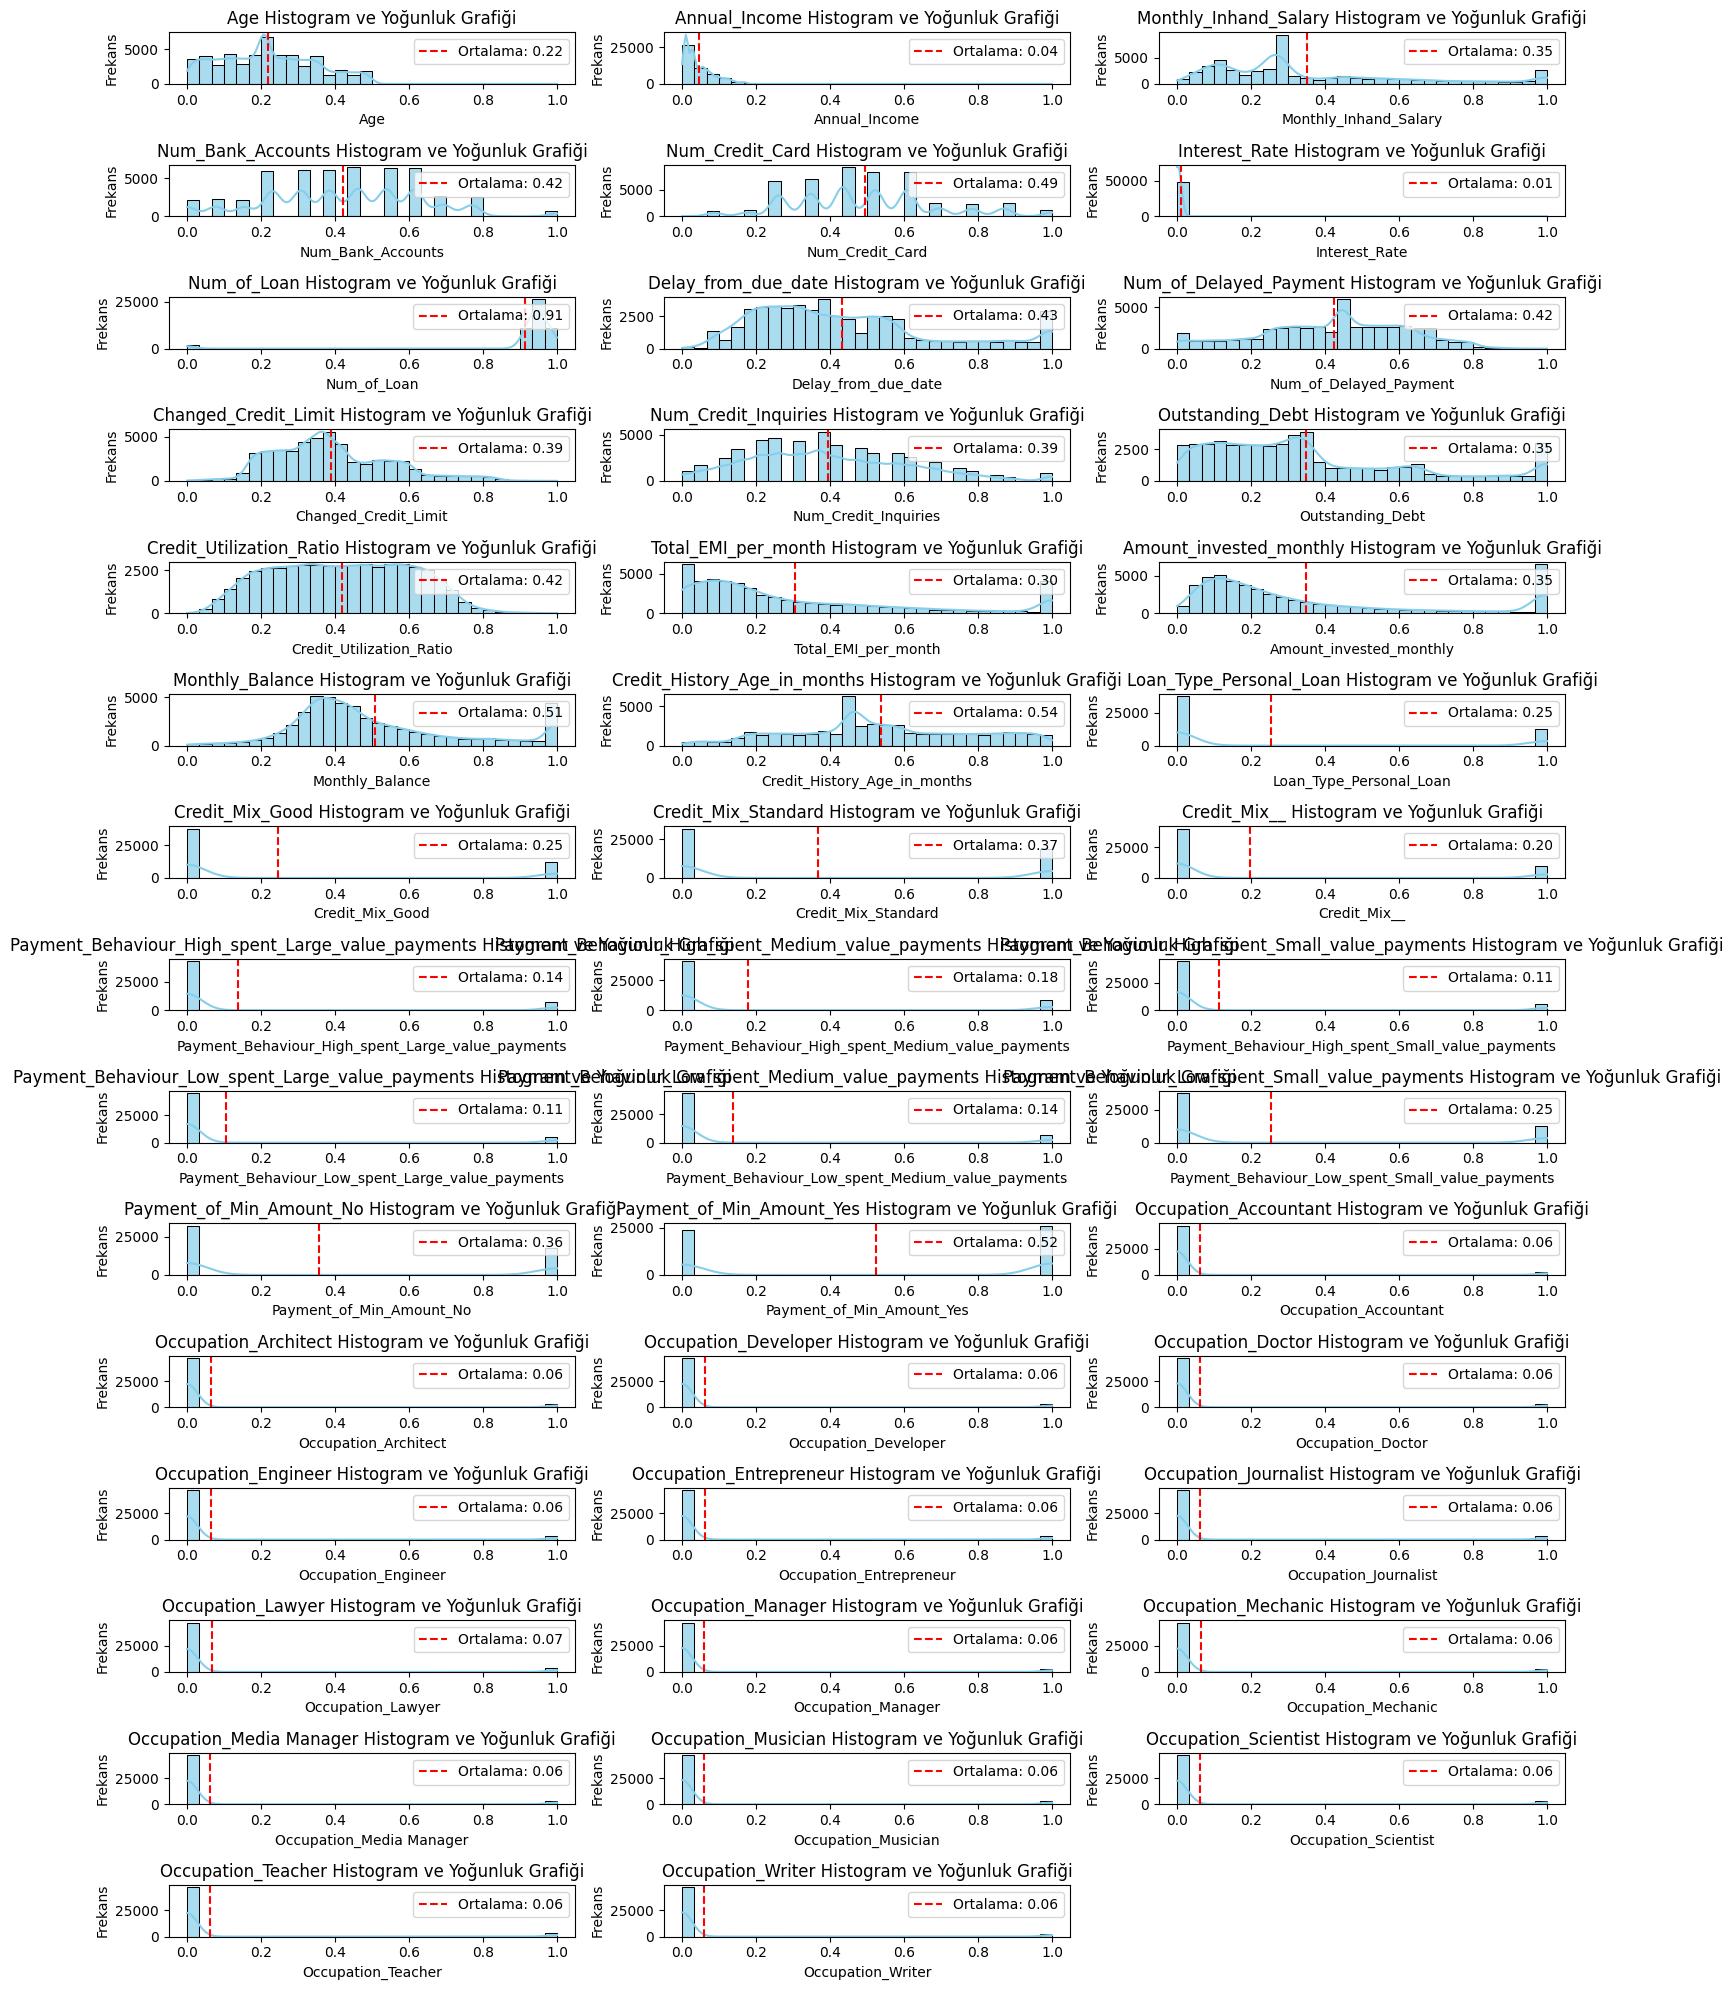

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(df, columns, bins=30, figsize=(15, 20), color='skyblue'):
    """
    Sayısal sütunlar için histogram ve yoğunluk grafiği çizer.
    Her grafikte veri seti ortalaması da kırmızı kesikli çizgi ile gösterilir.

    Parametreler:
    df (DataFrame): Veri seti
    columns (list): İncelenecek sütunların listesi
    bins (int): Histogramdaki kutucuk sayısı (varsayılan: 30)
    figsize (tuple): Grafiklerin toplam boyutu (varsayılan: 15x20)
    color (str): Histogramın rengi (varsayılan: 'skyblue')
    """
    plt.figure(figsize=figsize)  # Grafik alanını tanımla
    for i, col in enumerate(columns, 1):
        # Eğer sütun veri setinde yoksa, bu durumu atla
        if col not in df.columns:
            print(f"'{col}' sütunu veri setinde bulunamadı, atlanıyor.")
            continue

        # Her sütun için alt grafik oluştur
        plt.subplot((len(columns) + 2) // 3, 3, i)

        # Histogram ve yoğunluk grafiği çiz
        sns.histplot(df[col], kde=True, bins=bins, color=color, alpha=0.7)

        # Ortalama değeri hesapla ve kırmızı kesikli çizgi ile göster
        mean_val = df[col].mean()
        plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f"Ortalama: {mean_val:.2f}")

        # Grafiğin başlığını ve etiketlerini ayarla
        plt.title(f"{col} Histogram ve Yoğunluk Grafiği")
        plt.legend(loc="upper right")  # Ortalamayı belirten etiketi sağ üst köşeye yerleştir
        plt.xlabel(f"{col}")
        plt.ylabel("Frekans")

    plt.tight_layout()  # Grafiklerin düzenli görünmesi için sıkıştırma
    plt.show()  # Grafiklerin gösterilmesi

# Sayısal sütunları seçiyoruz
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Histogramları çiziyoruz
plot_histograms(data, numeric_columns)

**4.2 Korelasyon matrisi**

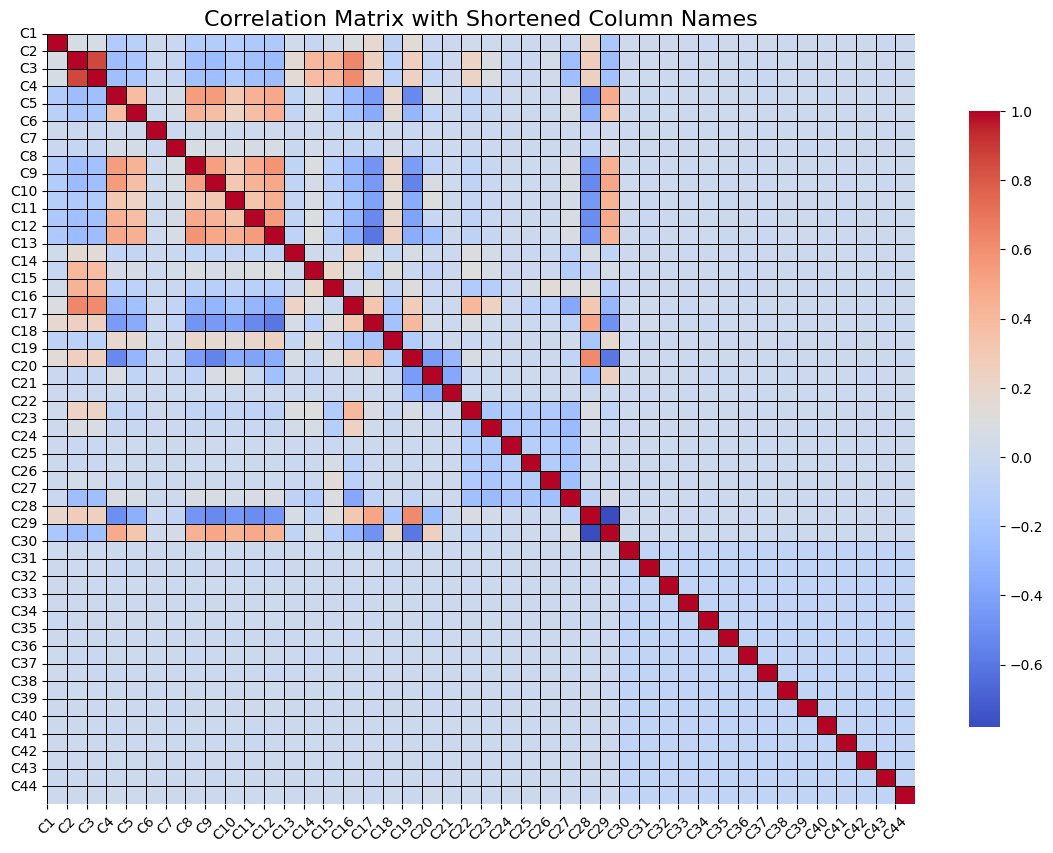

Feature Name Mapping:
C1: Age
C2: Annual_Income
C3: Monthly_Inhand_Salary
C4: Num_Bank_Accounts
C5: Num_Credit_Card
C6: Interest_Rate
C7: Num_of_Loan
C8: Delay_from_due_date
C9: Num_of_Delayed_Payment
C10: Changed_Credit_Limit
C11: Num_Credit_Inquiries
C12: Outstanding_Debt
C13: Credit_Utilization_Ratio
C14: Total_EMI_per_month
C15: Amount_invested_monthly
C16: Monthly_Balance
C17: Credit_History_Age_in_months
C18: Loan_Type_Personal_Loan
C19: Credit_Mix_Good
C20: Credit_Mix_Standard
C21: Credit_Mix__
C22: Payment_Behaviour_High_spent_Large_value_payments
C23: Payment_Behaviour_High_spent_Medium_value_payments
C24: Payment_Behaviour_High_spent_Small_value_payments
C25: Payment_Behaviour_Low_spent_Large_value_payments
C26: Payment_Behaviour_Low_spent_Medium_value_payments
C27: Payment_Behaviour_Low_spent_Small_value_payments
C28: Payment_of_Min_Amount_No
C29: Payment_of_Min_Amount_Yes
C30: Occupation_Accountant
C31: Occupation_Architect
C32: Occupation_Developer
C33: Occupation_Doctor
C

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kolon isimlerini kısaltmak için bir eşleme sözlüğü oluştur
shortened_columns = {col: f"C{i}" for i, col in enumerate(data.columns, 1)}  # Kısa isimler oluştur
shortened_data = data.rename(columns=shortened_columns)  # Kısa isimleri veri setine uygula

# Korelasyon matrisini oluştur
correlation_matrix = shortened_data.corr(numeric_only=True)  # Sadece sayısal kolonlar

# Daha okunabilir ve estetik bir korelasyon matrisi görselleştirme
plt.figure(figsize=(14, 10))  # Figür boyutunu artır
sns.heatmap(
    correlation_matrix,
    annot=False,             # Değerleri kapat (fazla kolon varsa yer tasarrufu)
    fmt='.2f',               # Değerlerin formatı
    cmap='coolwarm',         # Renk paleti
    linewidths=0.5,          # Hücreler arasına çizgi ekle
    linecolor='black',       # Çizgi rengi
    cbar_kws={"shrink": 0.8}  # Renk barını küçült
)

# Başlık ve etiketler
plt.title('Correlation Matrix with Shortened Column Names', fontsize=16)  # Başlık
plt.xticks(
    ticks=range(len(correlation_matrix.columns)),
    labels=correlation_matrix.columns,
    rotation=45, fontsize=10
)  # X ekseni
plt.yticks(
    ticks=range(len(correlation_matrix.columns)),
    labels=correlation_matrix.columns,
    fontsize=10
)  # Y ekseni

# Grafiği göster
plt.show()

# Uzun kolon isimlerini kısa isimlerle eşleştirme tablosu
print("Feature Name Mapping:")
for original, short in shortened_columns.items():
    print(f"{short}: {original}")


**4.3 Scatterplot matrisi**

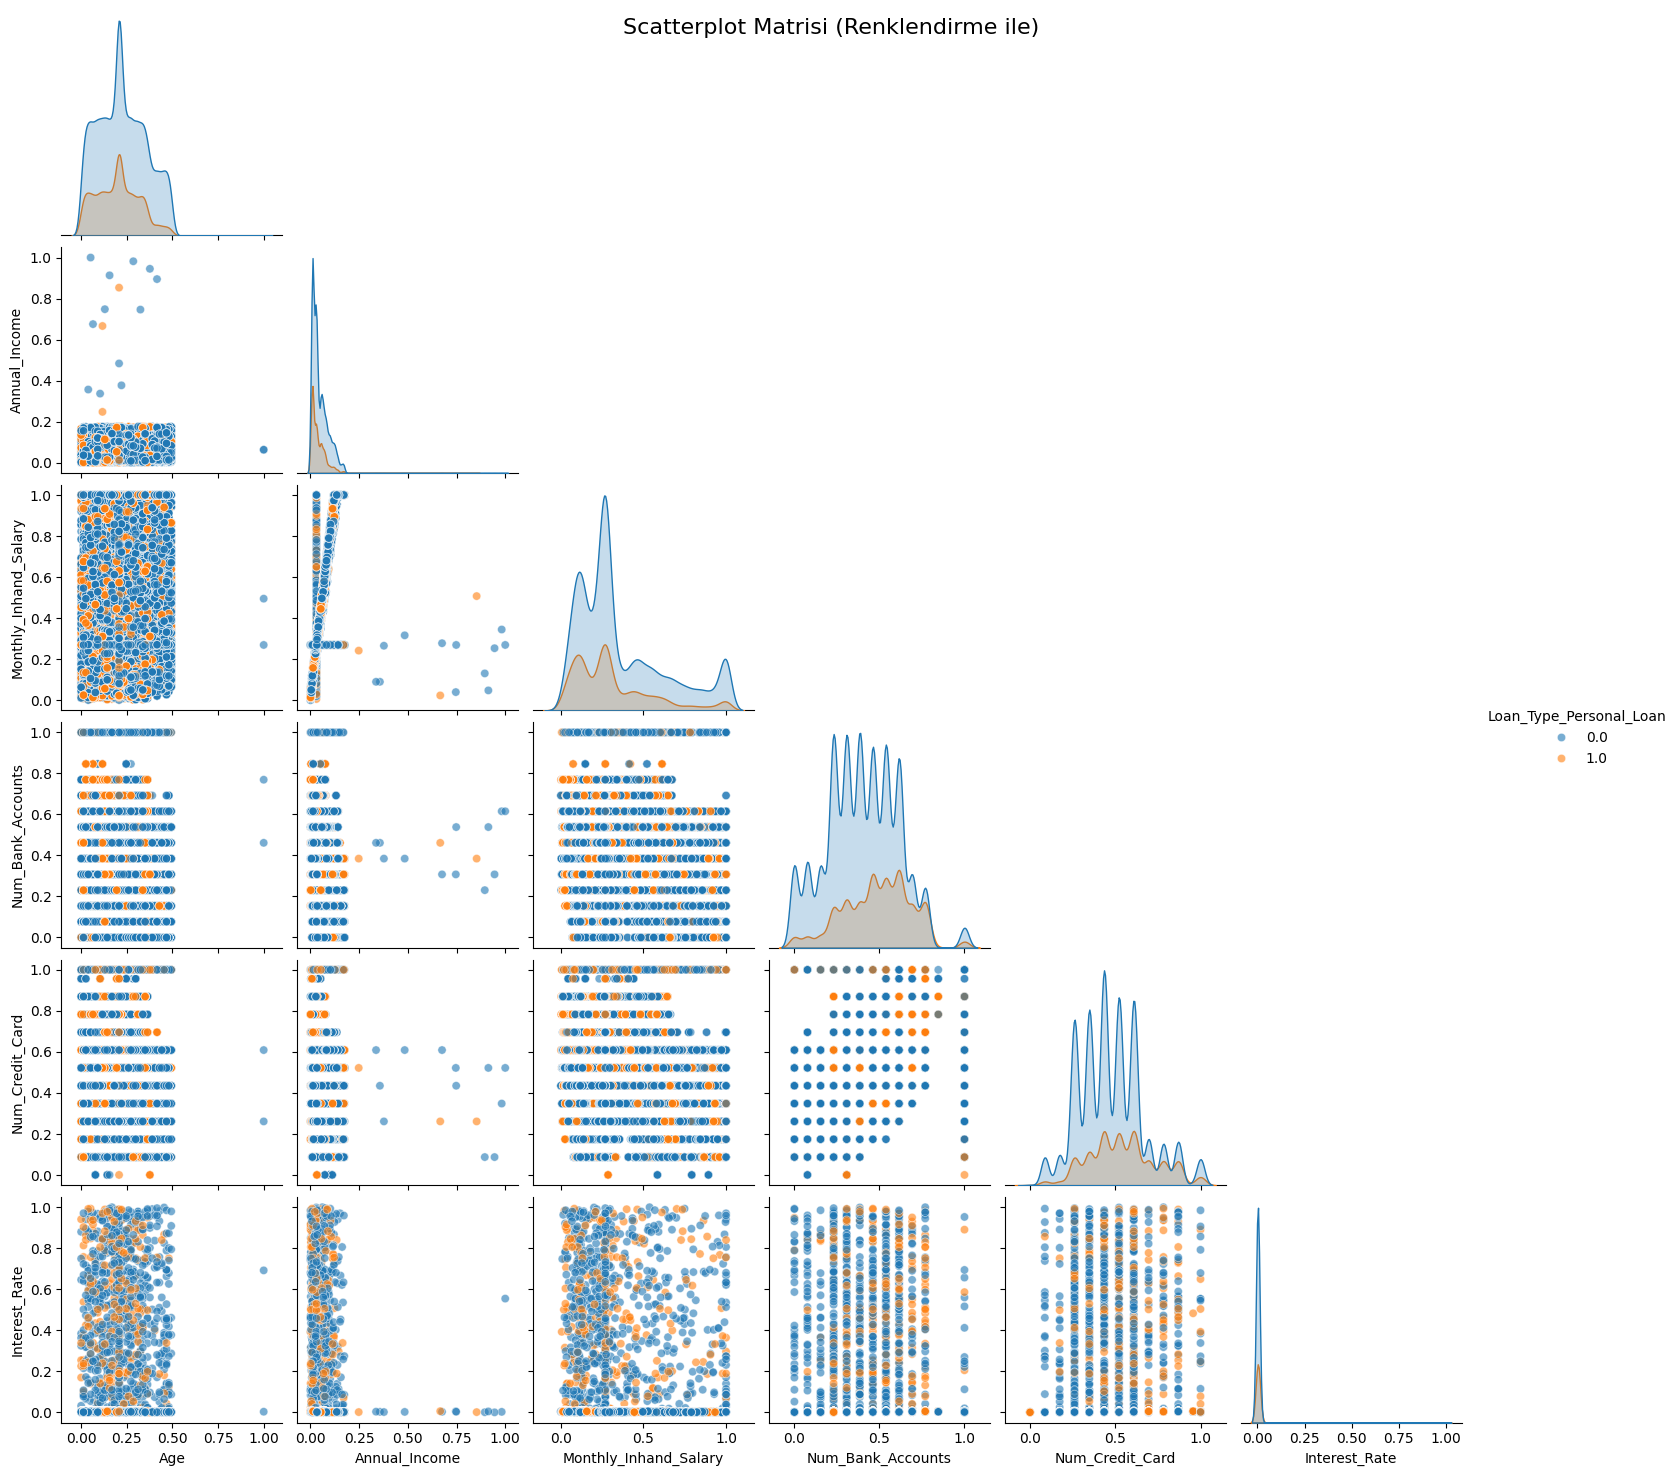

In [9]:
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

def plot_scatter_matrix(df, numeric_columns, hue_column=None, figsize=(15, 15)):
    """
    Scatterplot matrisini çizer ve isteğe bağlı olarak renklendirme yapar.

    Parametreler:
    df (DataFrame): Veri seti
    numeric_columns (list): Scatterplot matrisinde kullanılacak sayısal sütunlar
    hue_column (str): Renklendirme için kullanılacak kategorik sütun (varsayılan: None)
    figsize (tuple): Scatterplot matrisi boyutu (varsayılan: 15x15)
    """
    if hue_column and hue_column in df.columns:
        # Eğer renklendirme için verilen sütun veri setinde varsa, PairPlot kullan
        sns.pairplot(
            df,
            vars=numeric_columns,
            hue=hue_column,  # Renklendirme için kategorik sütun
            diag_kind='kde',  # Diyagonal çizim türü (yoğunluk grafiği)
            corner=True,  # Üst üçgen grafikleri kaldır
            height=2.5,   # Alt grafiklerin boyutu
            plot_kws={'alpha': 0.6}  # Nokta saydamlığı ayarı
        )
        plt.suptitle("Scatterplot Matrisi (Renklendirme ile)", size=16)  # Genel başlık
    else:
        # Eğer renklendirme yapılmayacaksa, scatter_matrix kullan
        scatter_matrix(
            df[numeric_columns],
            figsize=figsize,  # Matris boyutu
            diagonal='kde',  # Diyagonal çizim türü (yoğunluk grafiği)
            alpha=0.5,  # Nokta saydamlığı
            color='blue'  # Nokta rengi
        )
        plt.suptitle("Scatterplot Matrisi", size=16)  # Genel başlık
    plt.show()

# Sayısal sütunları seçiyoruz
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns[:6]  # İlk 6 sayısal sütun
hue_column = 'Loan_Type_Personal_Loan'  # Renklendirme için kullanılacak kategorik sütun

# `hue_column` veri setinde mevcut değilse kontrol ekliyoruz
if hue_column not in data.columns:
    print(f"'{hue_column}' sütunu bulunamadı. Renklendirme olmadan çizim yapılacak.")
    hue_column = None

# Scatterplot matrisi çiziyoruz
plot_scatter_matrix(data, numeric_columns, hue_column=hue_column)

**4.4 Sınıf dağılımının görselleştirilmesi**

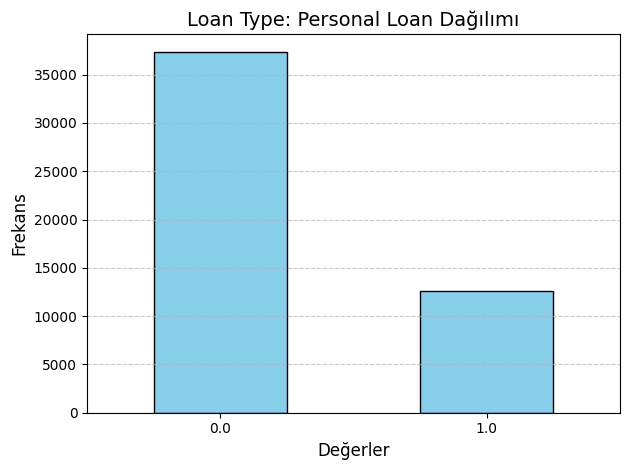

In [10]:
import matplotlib.pyplot as plt

# 'Loan_Type_Personal_Loan' sütunundaki değerlerin frekansını çubuk grafikle görselleştir
if 'Loan_Type_Personal_Loan' in data.columns:
    data['Loan_Type_Personal_Loan'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Loan Type: Personal Loan Dağılımı", fontsize=14)  # Grafik başlığı
    plt.xlabel("Değerler", fontsize=12)  # X ekseni etiketi
    plt.ylabel("Frekans", fontsize=12)  # Y ekseni etiketi
    plt.xticks(rotation=0, fontsize=10)  # X ekseni etiketlerinin döndürülmesi
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y eksenine grid ekleme
    plt.tight_layout()  # Grafiğin sıkışıklığını azalt
    plt.show()  # Grafiği göster
else:
    print("'Loan_Type_Personal_Loan' sütunu veri setinde bulunamadı.")

**4.5 Sayısal değişkenlerin dağılımının görselleştirilmesi**

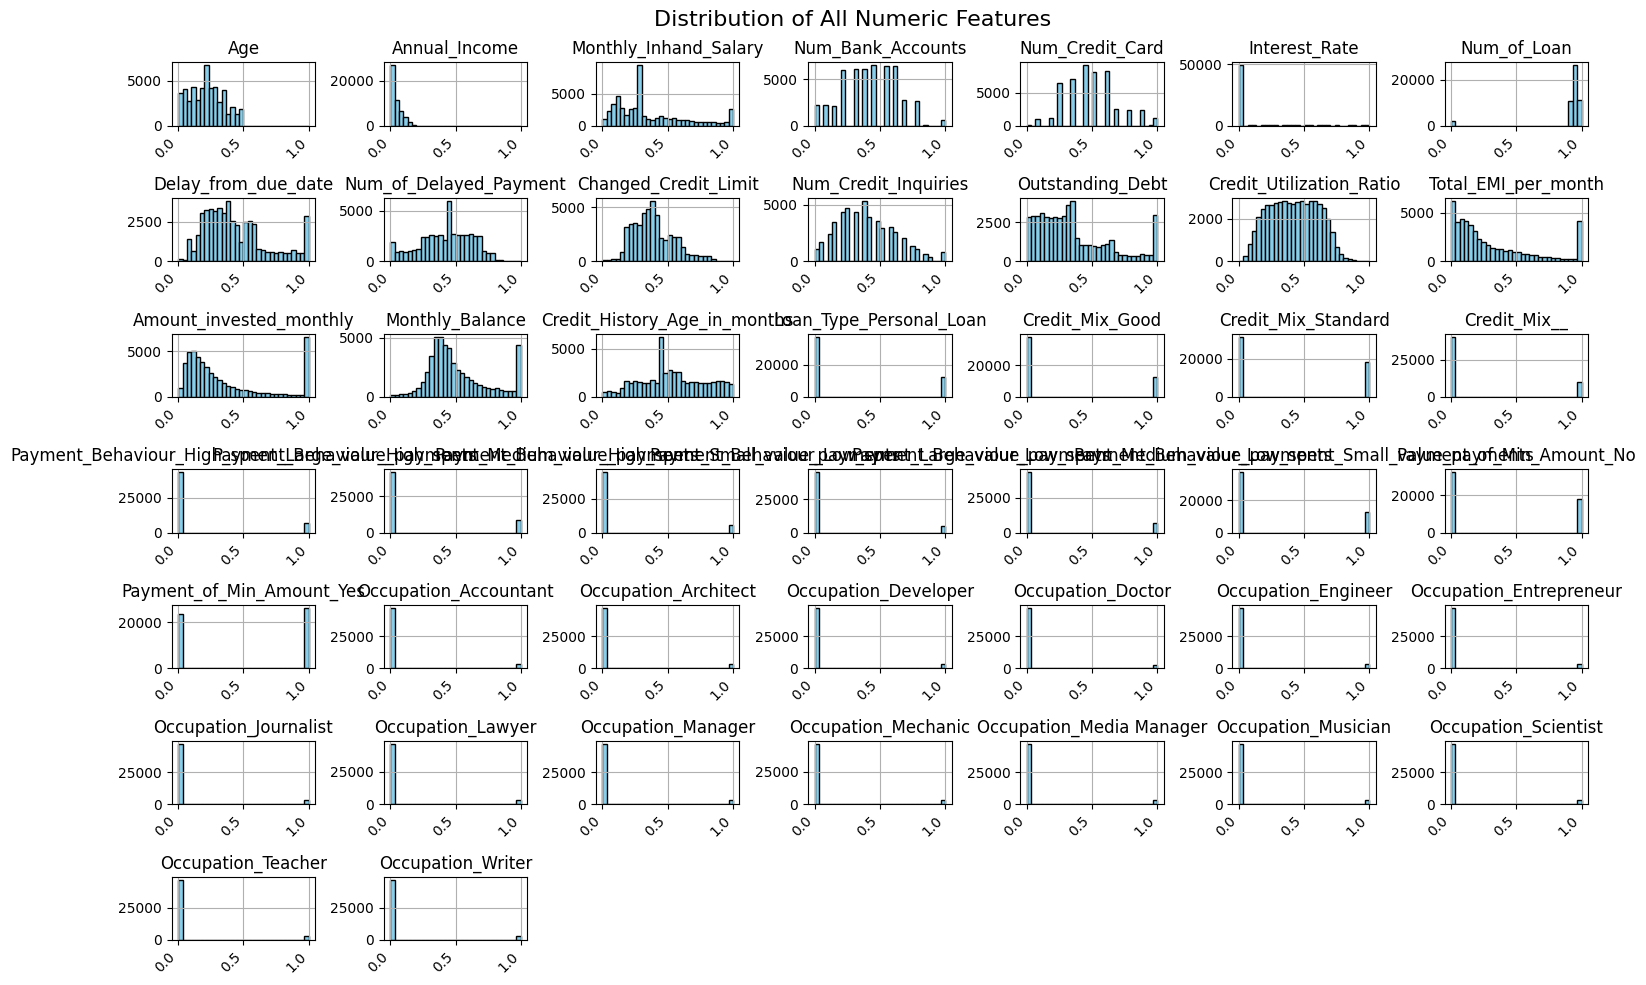

In [11]:
import matplotlib.pyplot as plt

# Sadece sayısal sütunları seçiyoruz
numeric_data = data.select_dtypes(include=['number'])

# Histogramları çizdiriyoruz
numeric_data.hist(figsize=(15, 10), bins=30, color='skyblue', edgecolor='black')  # Histogram ayarları
plt.suptitle('Distribution of All Numeric Features', fontsize=16)  # Üst başlık ekleniyor

# X ekseni etiketlerini ayarlıyoruz
for axis in plt.gcf().axes:  # Grafik üzerindeki tüm eksenleri döngüye alıyoruz
    plt.sca(axis)  # Aktif ekseni seçiyoruz
    plt.xticks(rotation=45, ha='right')  # X ekseni etiketlerini 45 derece döndürüp sağa hizalıyoruz

plt.tight_layout()  # Grafiğin sıkışmasını önlüyor
plt.show()  # Grafiği görüntülüyoruz


**4.6 Sayısal değişkenler ile hedef değişken arasındaki ilişkinin görselleştirilmesi**

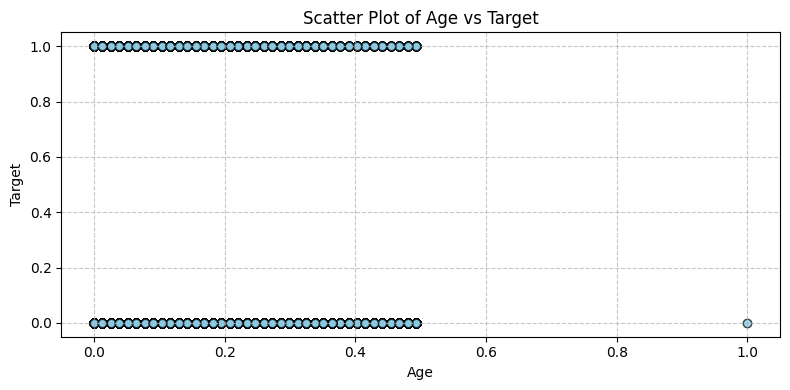

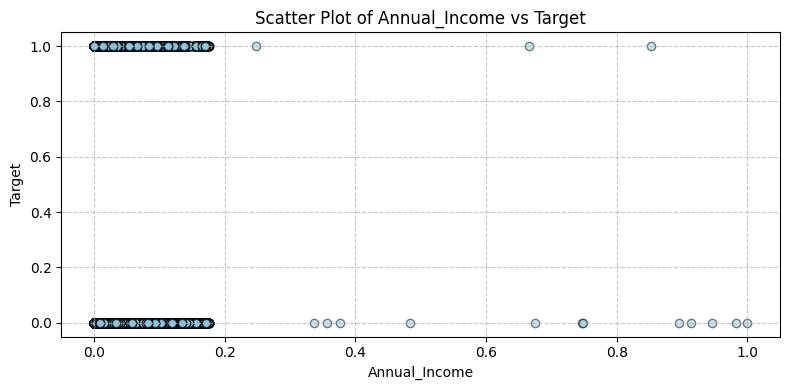

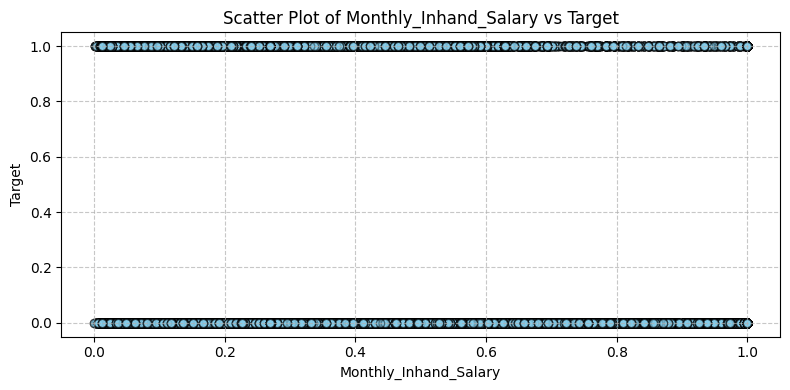

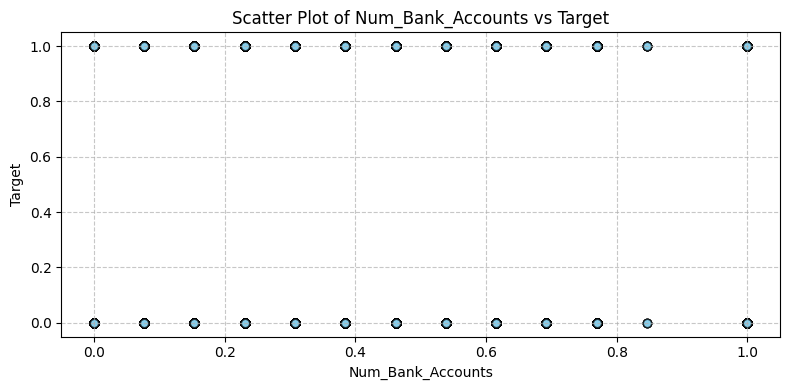

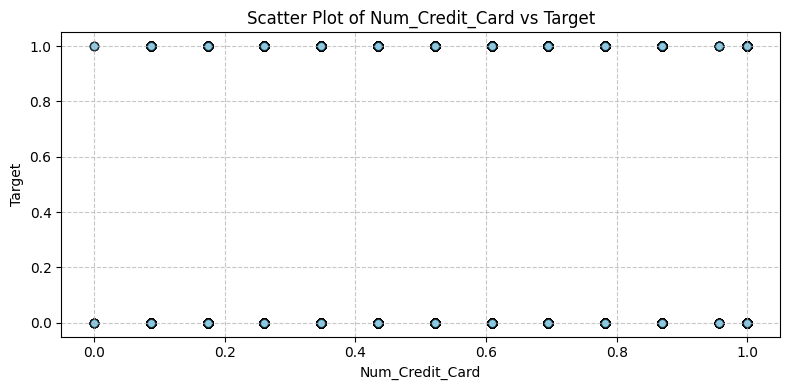

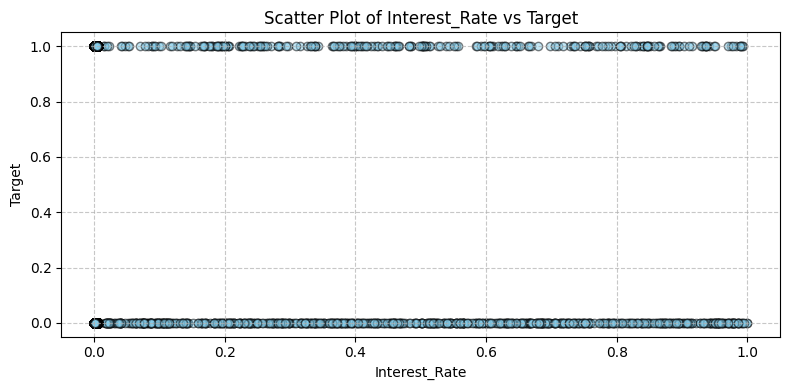

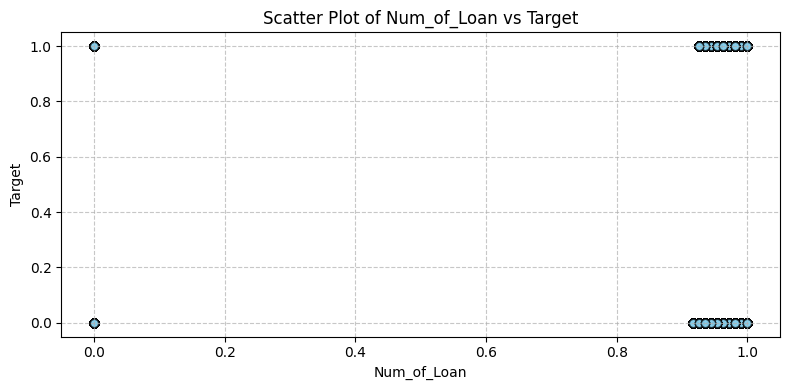

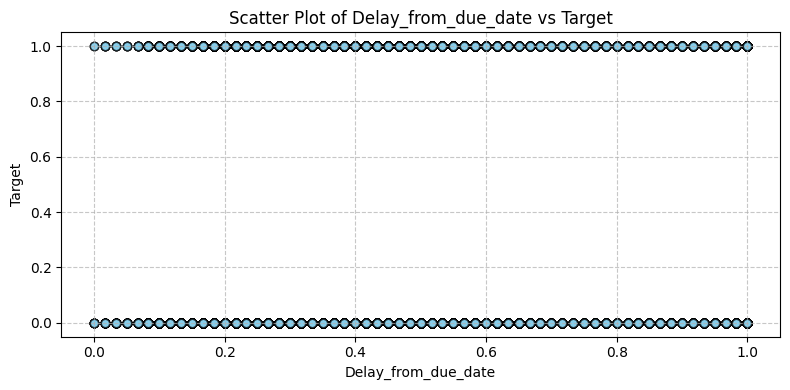

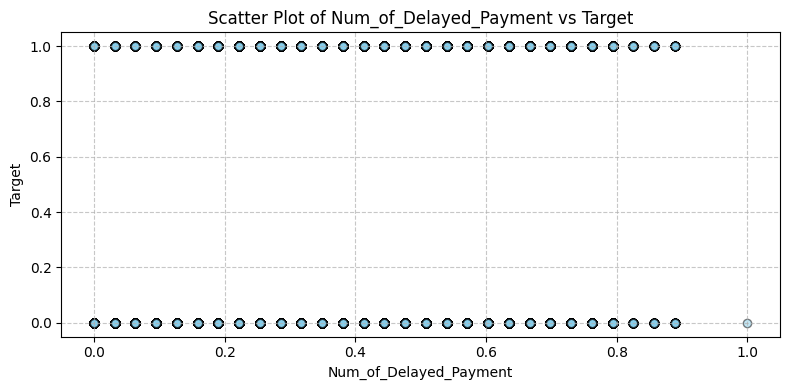

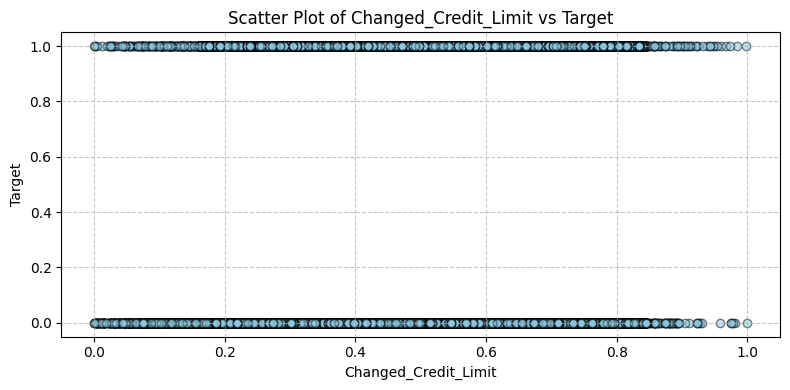

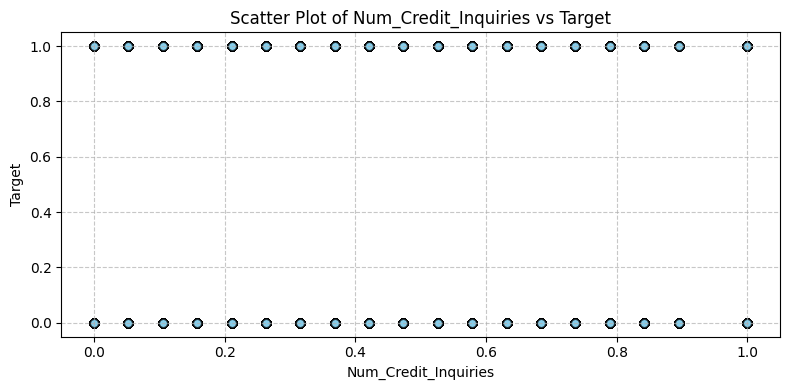

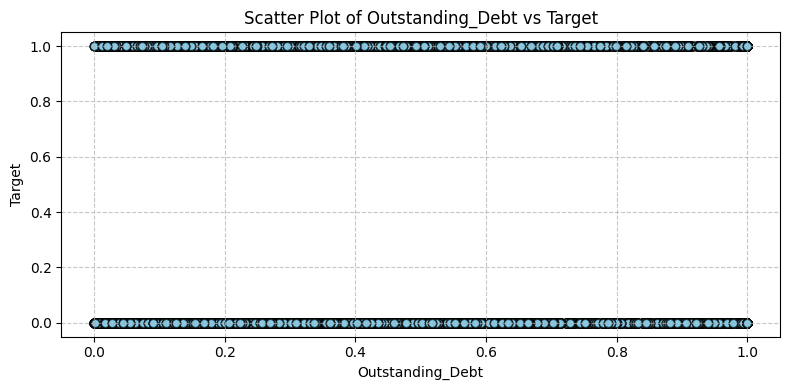

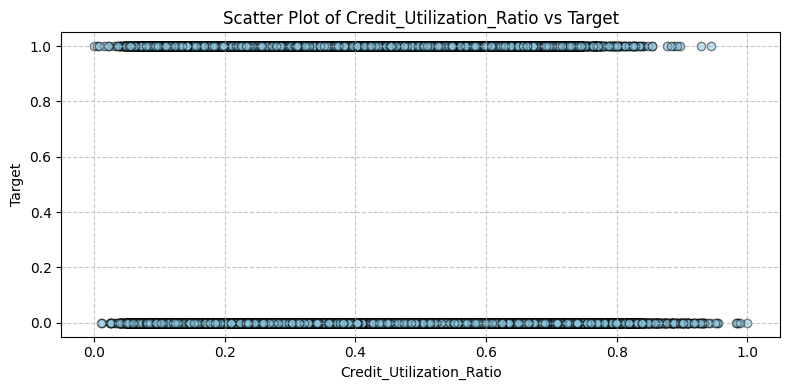

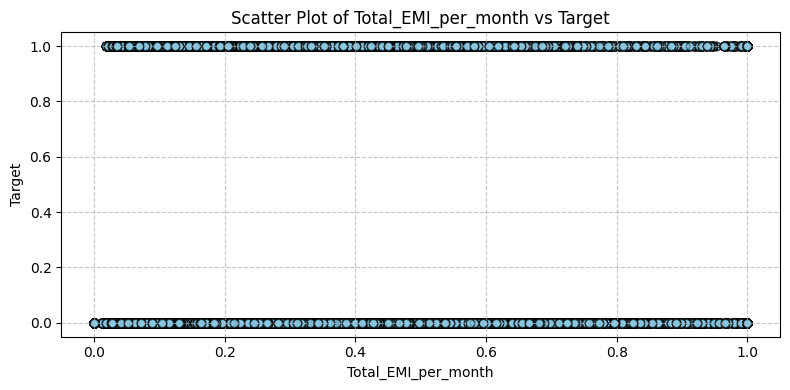

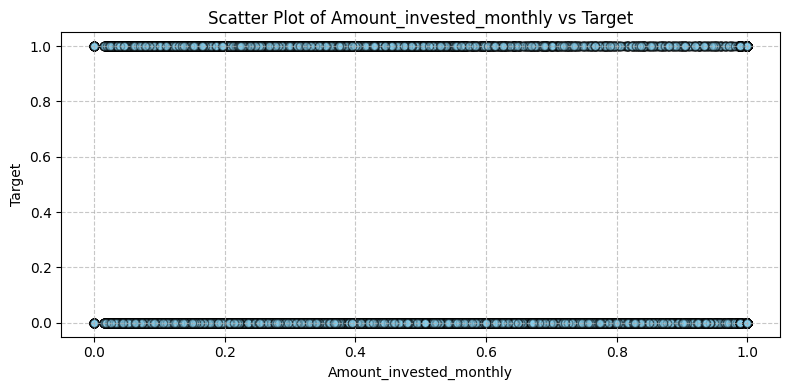

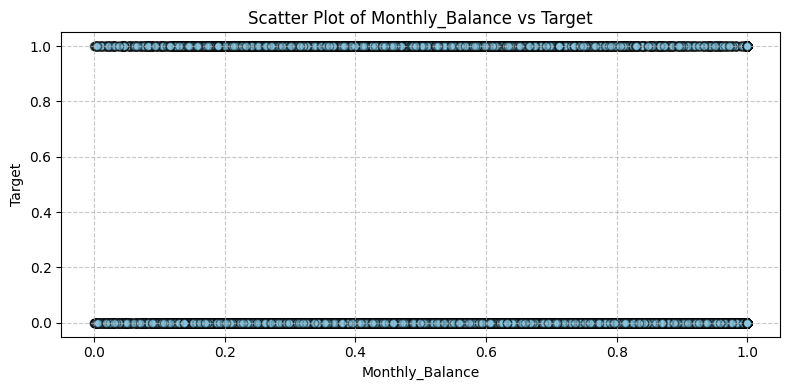

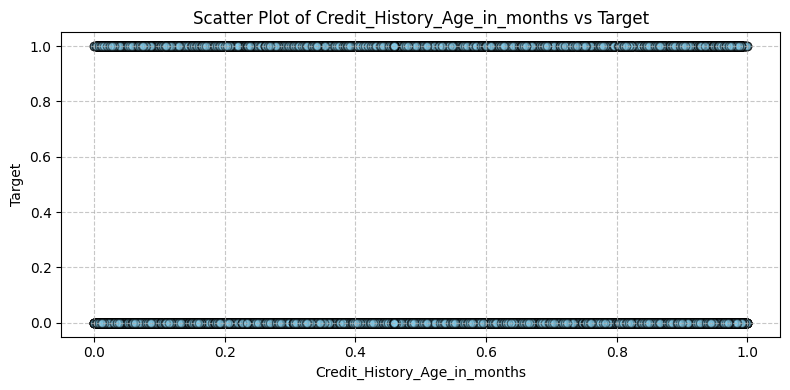

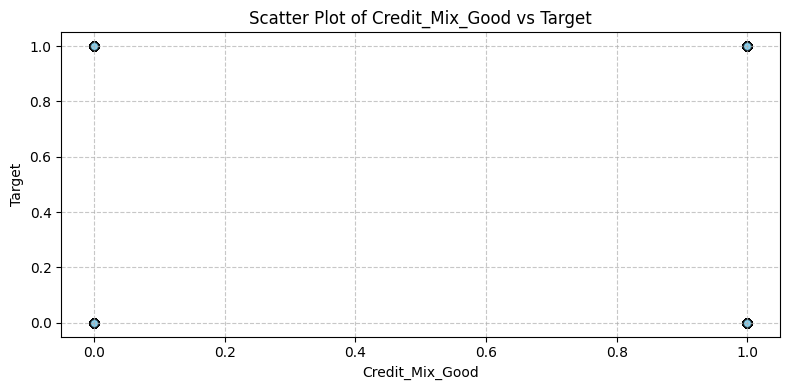

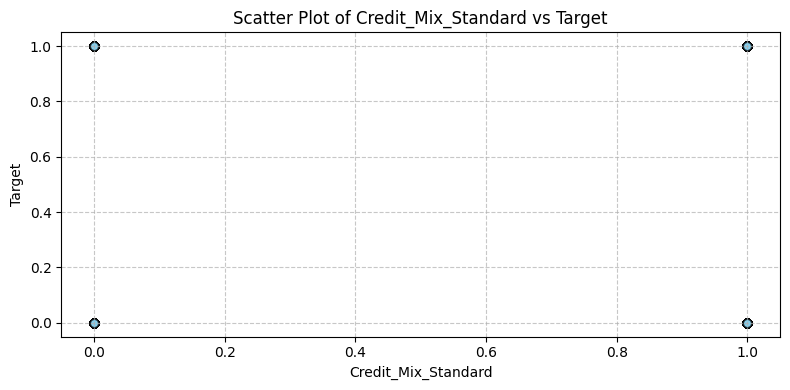

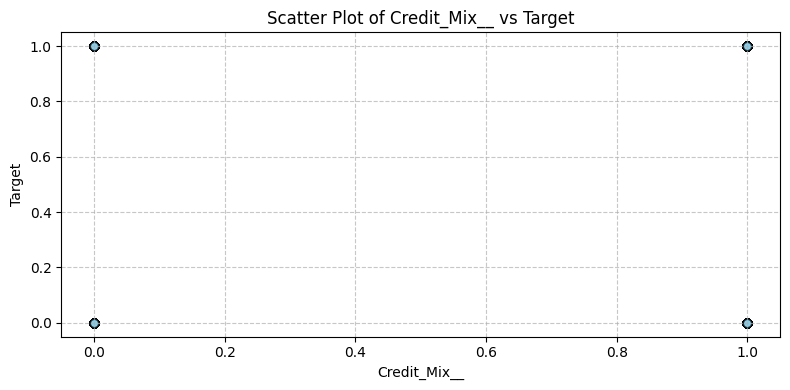

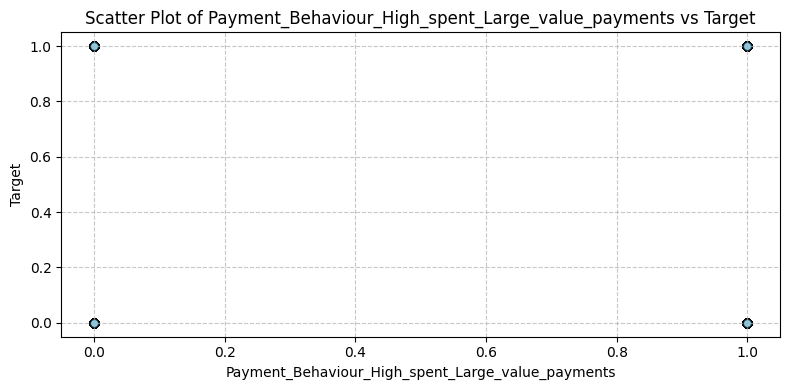

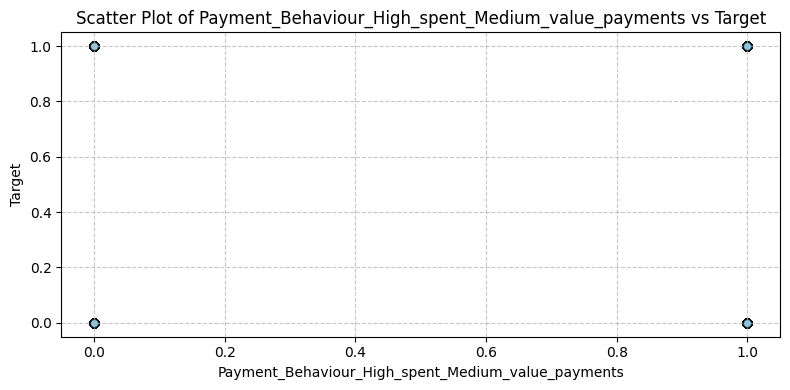

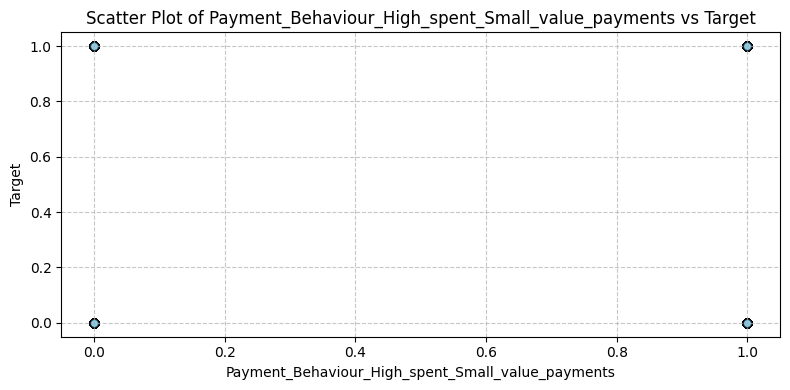

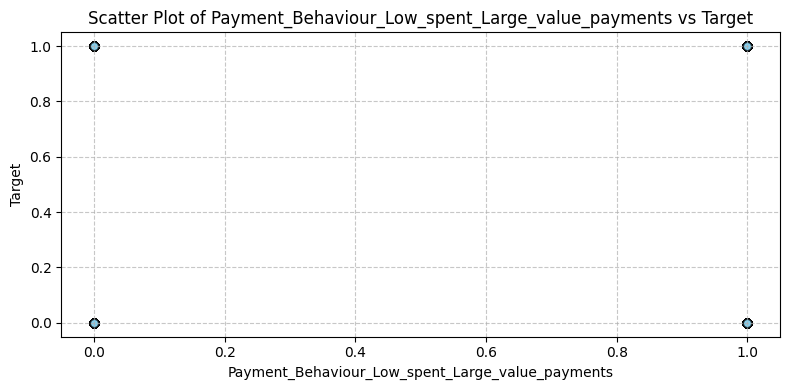

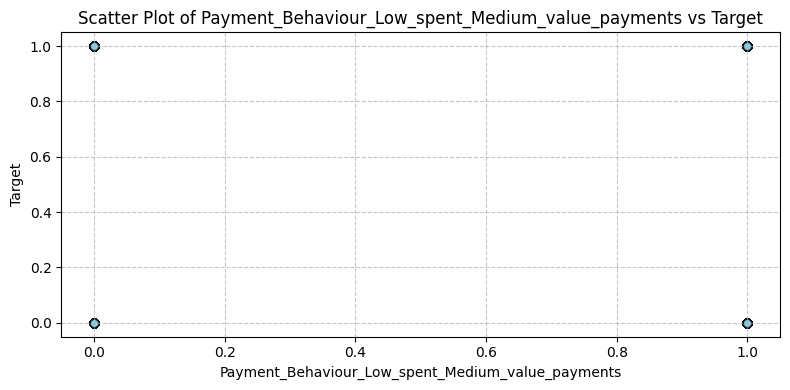

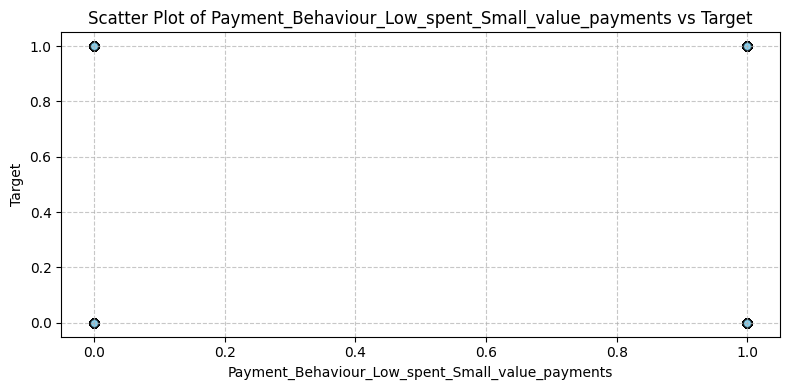

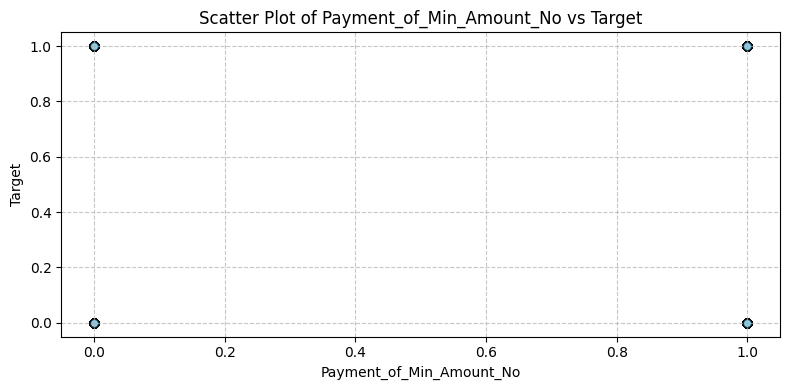

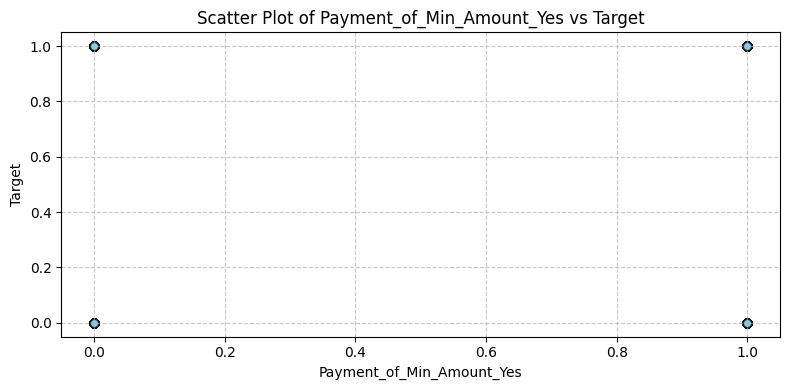

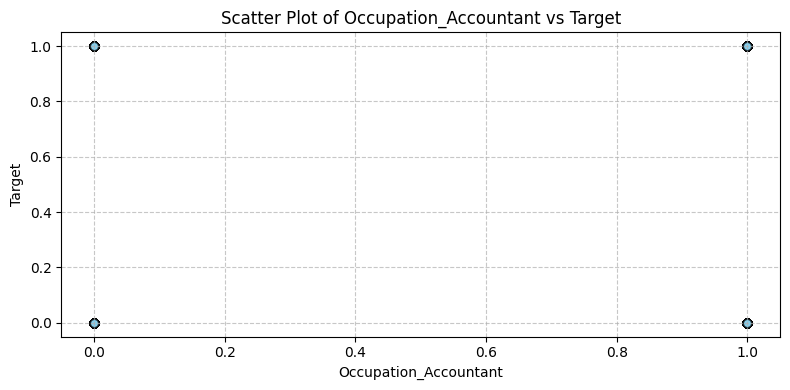

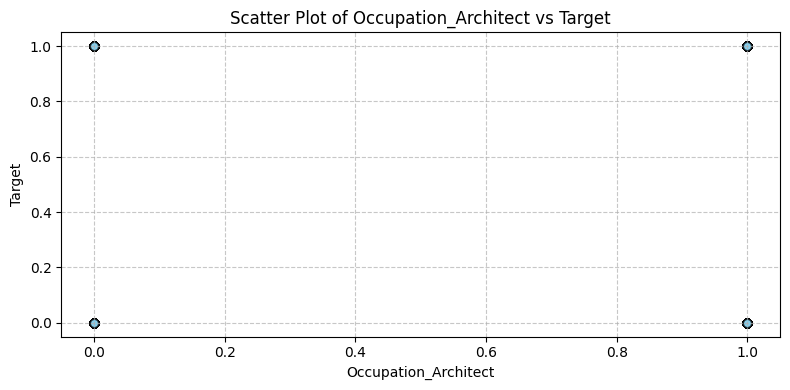

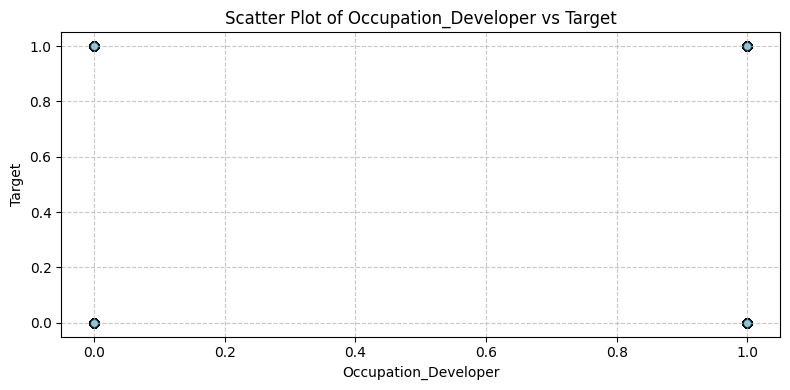

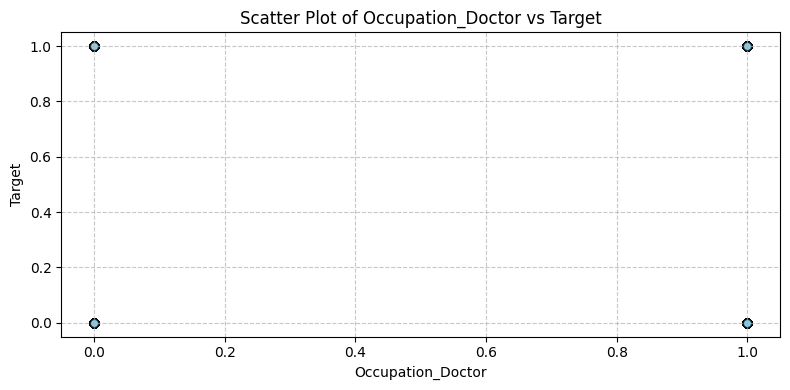

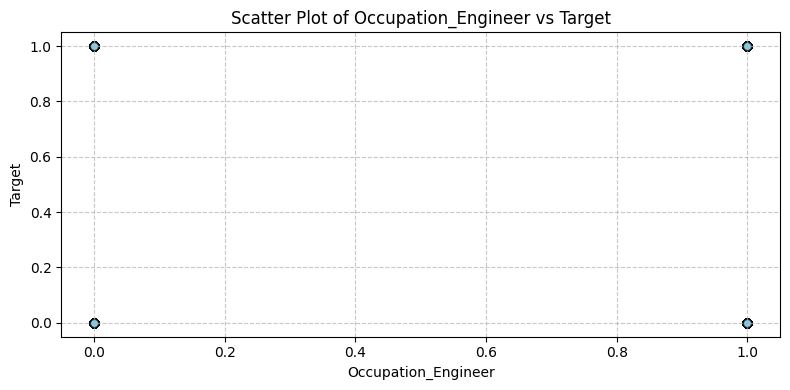

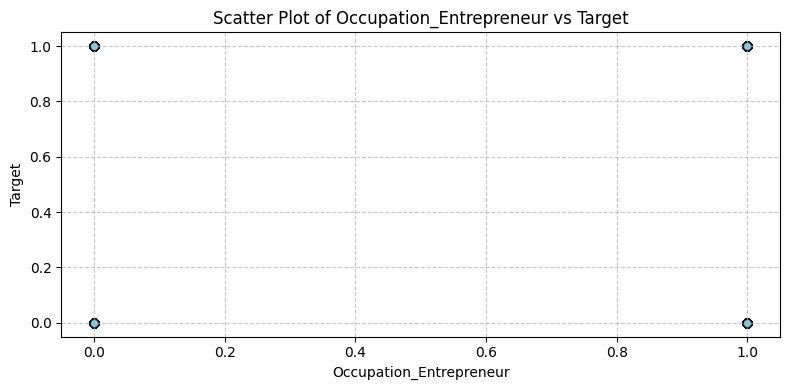

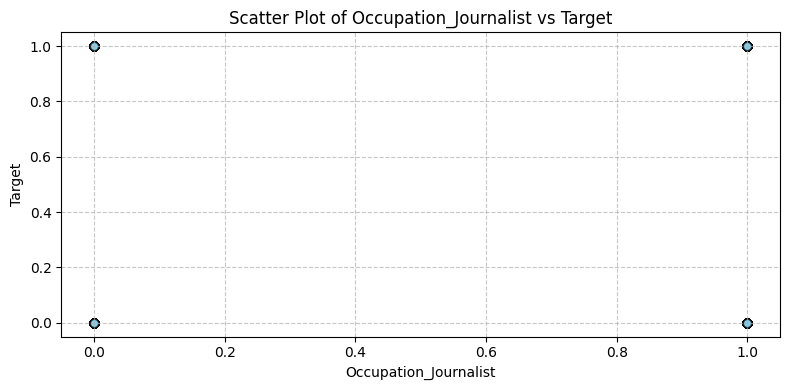

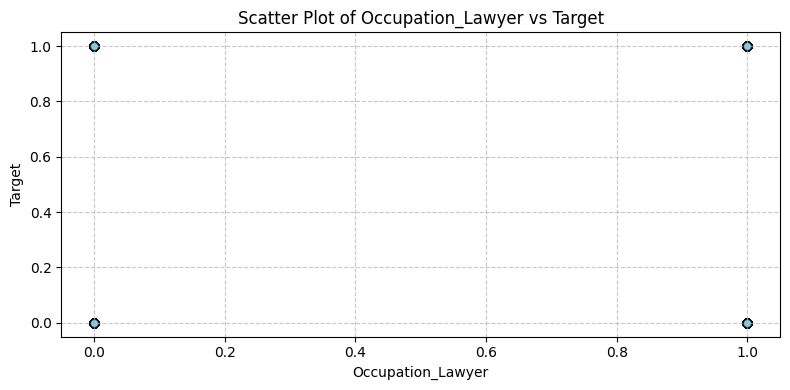

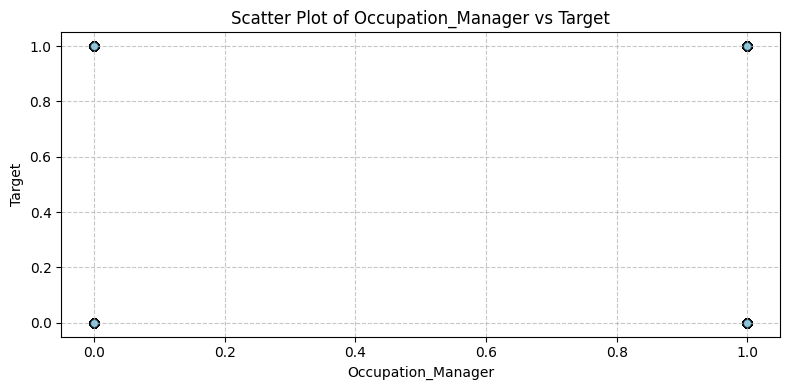

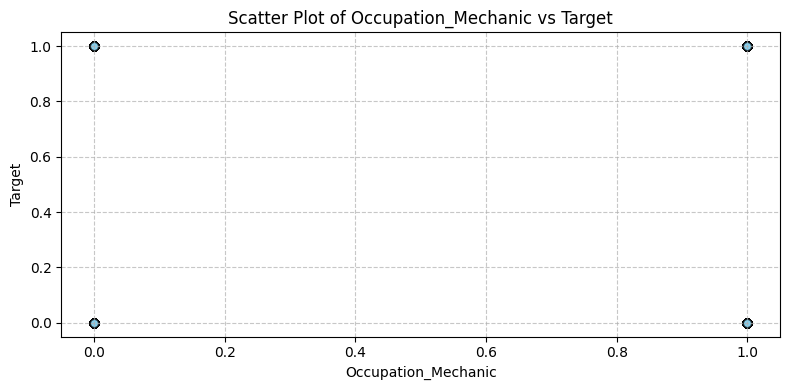

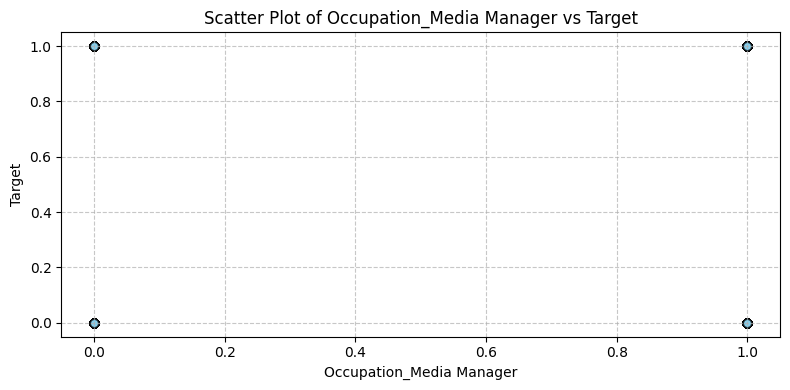

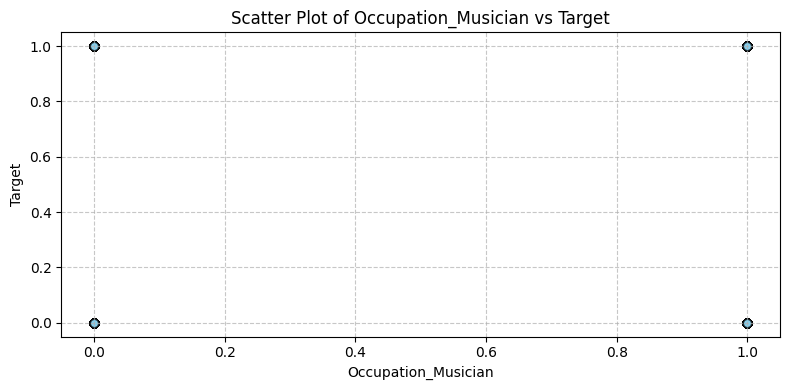

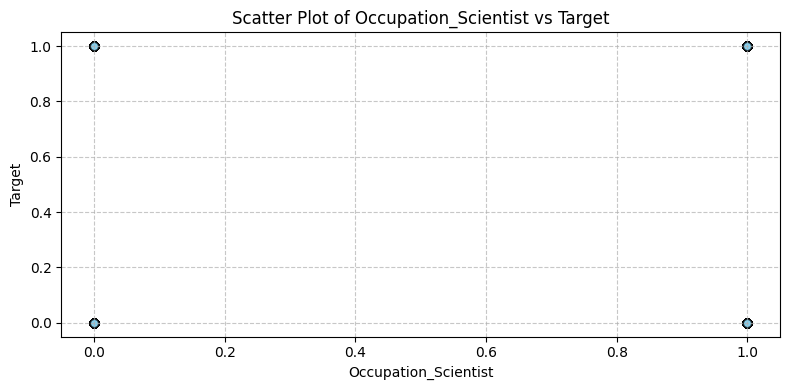

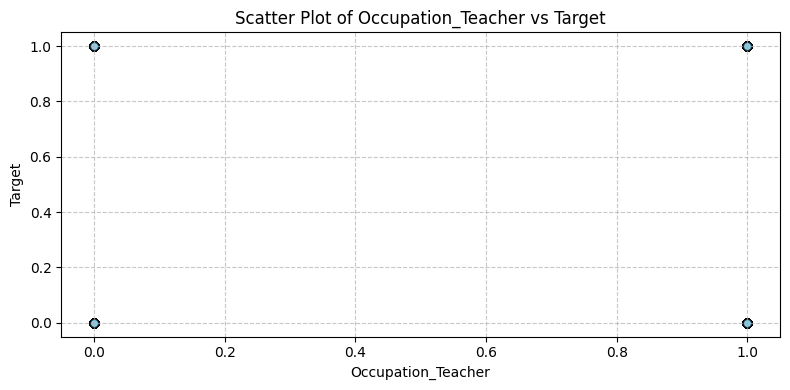

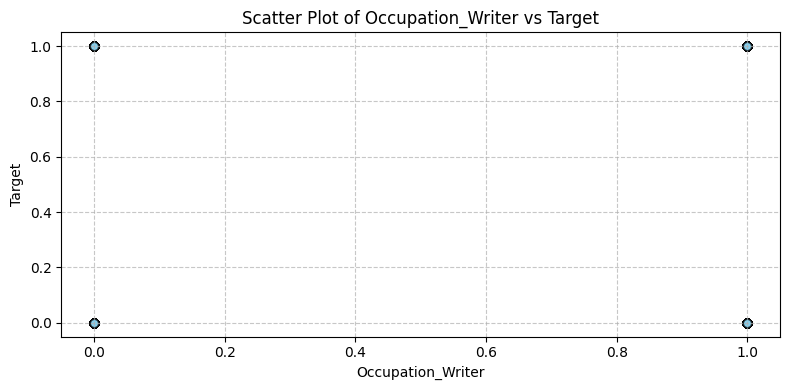

In [12]:
# Hedef değişkeni ve özellikleri tanımlıyoruz
target = data['Loan_Type_Personal_Loan']  # Hedef değişken (örnekte Loan_Type_Personal_Loan kullanılıyor)
features = data.drop(columns=['Loan_Type_Personal_Loan'])  # Hedef değişken hariç tüm özellikler

# Her bir özelliği hedef değişken ile karşılaştırarak scatter plot çiziyoruz
for feature_name in features.columns:
    plt.figure(figsize=(8, 4))  # Her bir grafik için boyut ayarı
    plt.scatter(features[feature_name], target, alpha=0.5, color='skyblue', edgecolor='black')  # Nokta grafiği
    plt.title(f'Scatter Plot of {feature_name} vs Target')  # Grafik başlığı
    plt.xlabel(feature_name)  # X ekseni etiketi
    plt.ylabel('Target')  # Y ekseni etiketi
    plt.grid(True, linestyle='--', alpha=0.7)  # Izgara ekleme
    plt.tight_layout()  # Grafik düzenini iyileştirme
    plt.show()  # Grafiği görüntüleme


**4.7 Çift değişkenli ilişkilerin görselleştirilmesi**

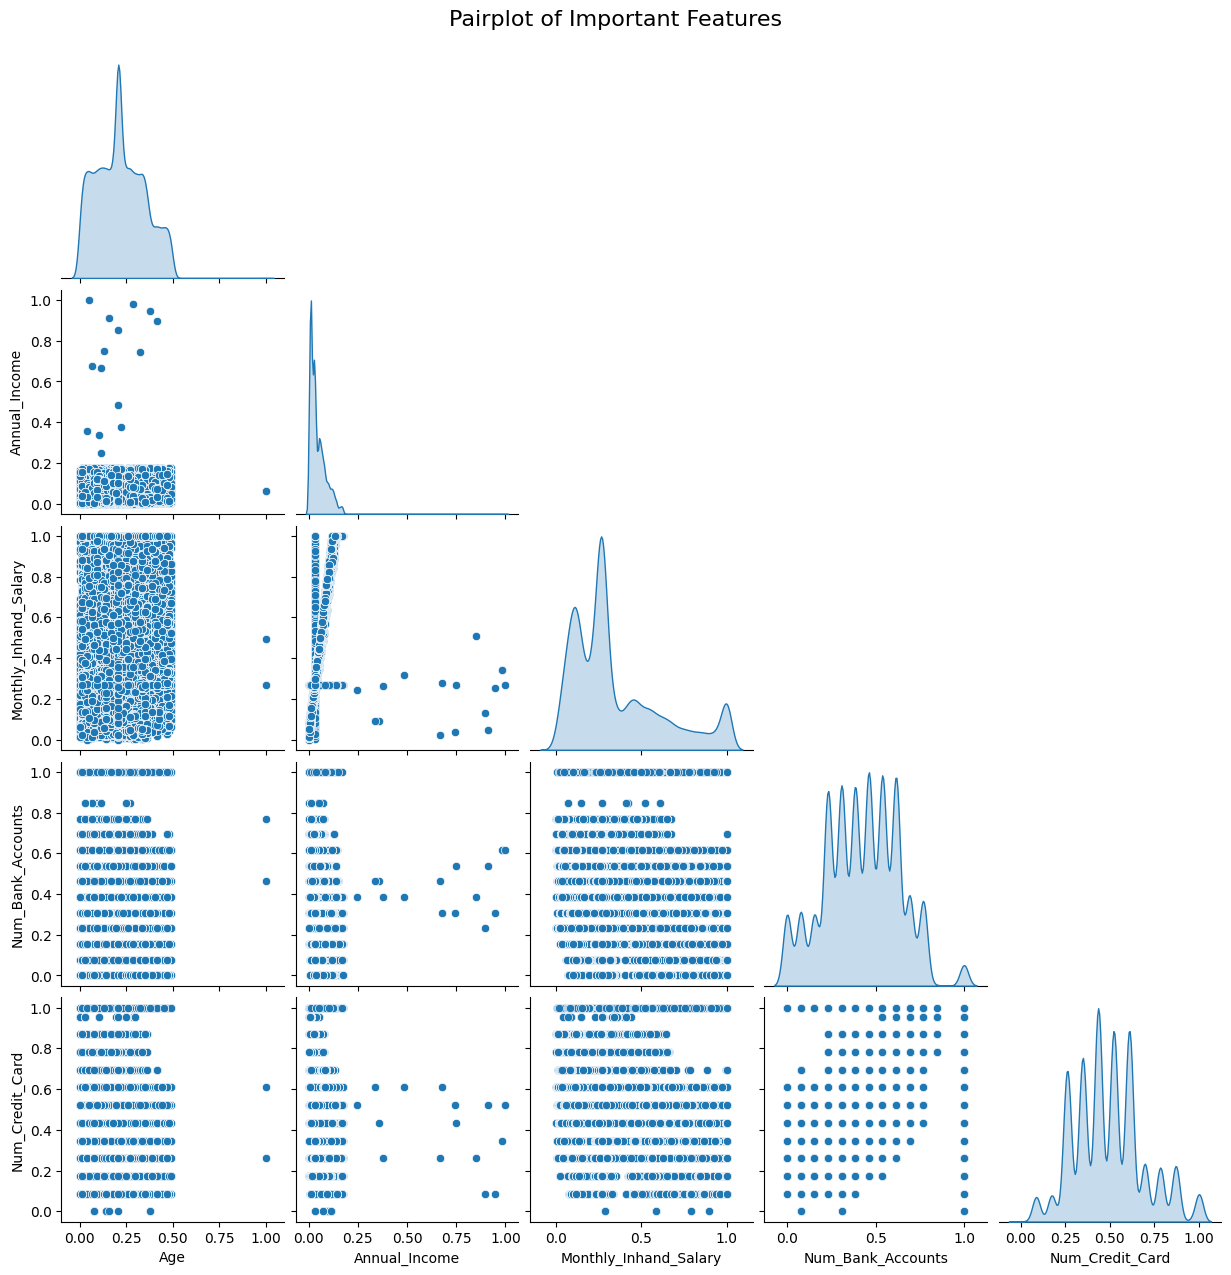

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Önemli özellikleri belirliyoruz
important_features = features.columns[:5]  # İlk 5 önemli özelliği seçiyoruz. Bu liste, model sonuçlarına veya ön analize göre değiştirilebilir.

# Pairplot (Çiftli Dağılım Grafiği) çiziyoruz
sns.pairplot(features[important_features], diag_kind='kde', corner=True)
# diag_kind='kde': Diyagonal üzerindeki grafikler için kernel yoğunluk grafiği.
# corner=True: Sadece alt üçgen kısmı çizer, gereksiz tekrarları önler.

# Görselleştirmeyi gösteriyoruz
plt.suptitle("Pairplot of Important Features", size=16, y=1.02)  # Başlık ekleme
plt.show()

**4.8 Hedef değişken ile özellikler arasındaki korelasyon analizi**

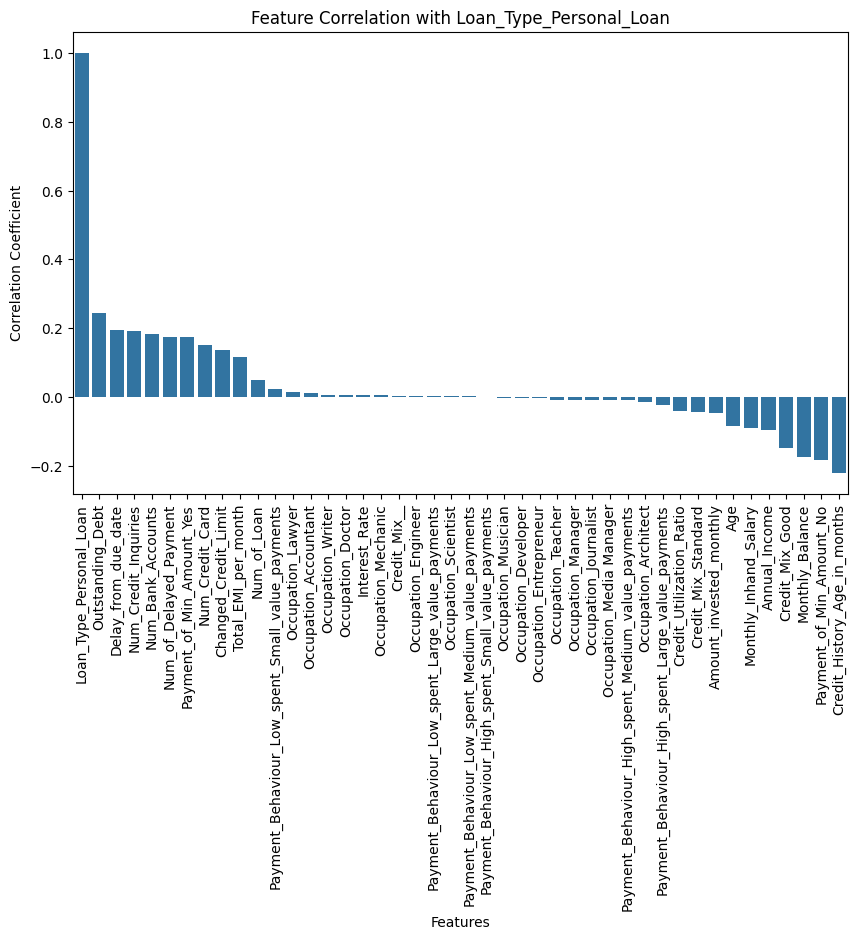

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hedef değişken ile tüm sayısal kolonlar arasındaki korelasyonu hesaplıyoruz
correlation_with_target = data.corr()['Loan_Type_Personal_Loan'].sort_values(ascending=False)

# Korelasyon değerlerini görselleştiriyoruz
plt.figure(figsize=(10, 6))# Grafik boyutlarını belirliyoruz
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
# Korelasyon değerlerini sütun grafiği olarak çiziyoruz.
plt.xticks(rotation=90) # X-ekseni etiketlerini döndürerek okunabilir hale getiriyoruz
plt.title('Feature Correlation with Loan_Type_Personal_Loan') # Grafik başlığı
plt.ylabel('Correlation Coefficient')  # Y-ekseni etiketi
plt.xlabel('Features') # X-ekseni etiketi
plt.show()


**4.9 Hedef değişken ile diğer değişkenler arasındaki korelasyonların sıralanması**

In [15]:
# Hedef değişkenle korelasyon hesaplama
target_column = 'C18'  # Loan_Type_Personal_Loan olarak hedef değişken tanımlanıyor
target_correlation = correlation_matrix[target_column].sort_values(ascending=False)
# Hedef değişken ile diğer sütunlar arasındaki korelasyonları azalan sıraya göre sıralıyoruz

# En yüksek korelasyonlu kolonları yazdırıyoruz
print("Top Correlated Features with Target:")  # Hedef değişken ile en yüksek korelasyonlu sütunları gösteriyoruz
print(target_correlation.head(10))  # İlk 10 korelasyonu yazdırıyoruz

Top Correlated Features with Target:
C18    1.000000
C12    0.245044
C8     0.195716
C11    0.192320
C4     0.182252
C9     0.174864
C29    0.174276
C5     0.152663
C10    0.138026
C14    0.116807
Name: C18, dtype: float64


**4.10 BoxPlot**

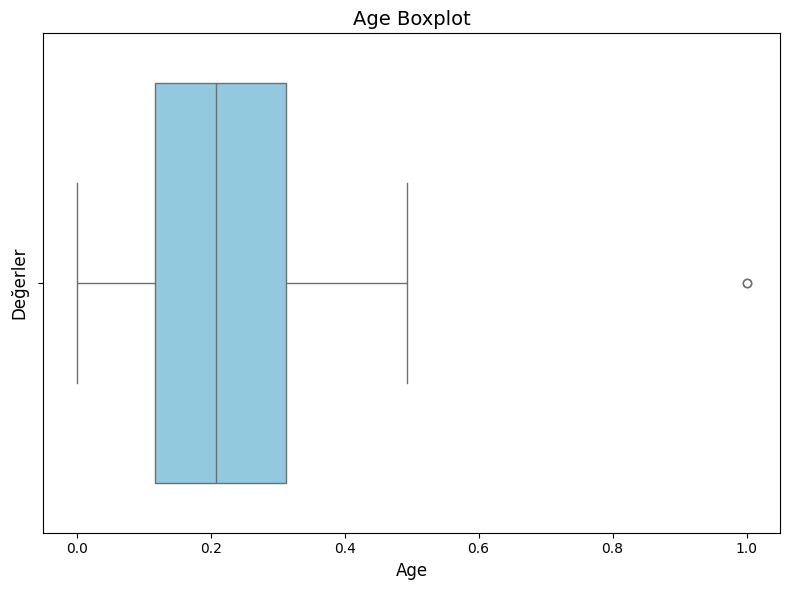

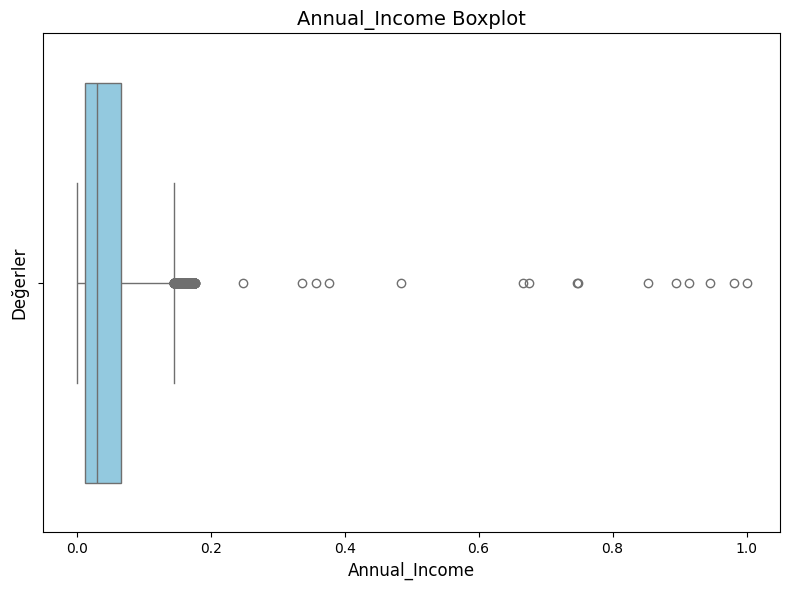

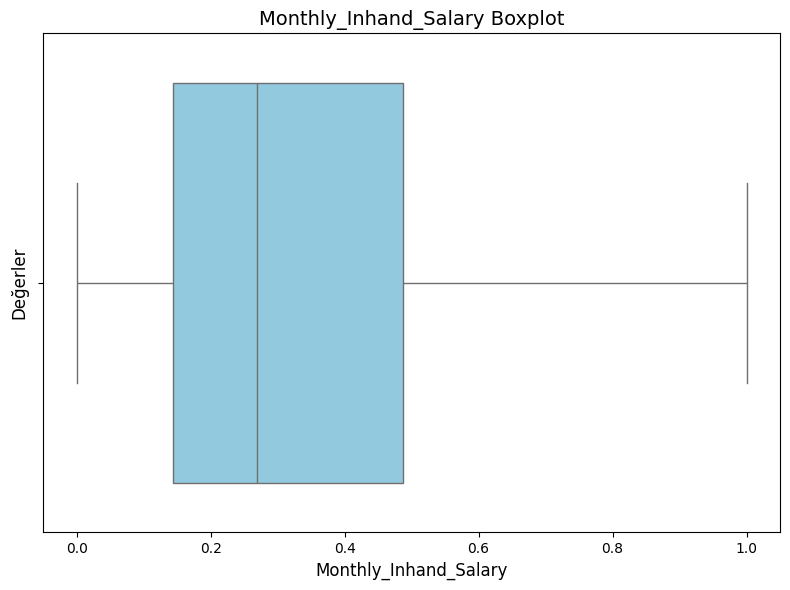

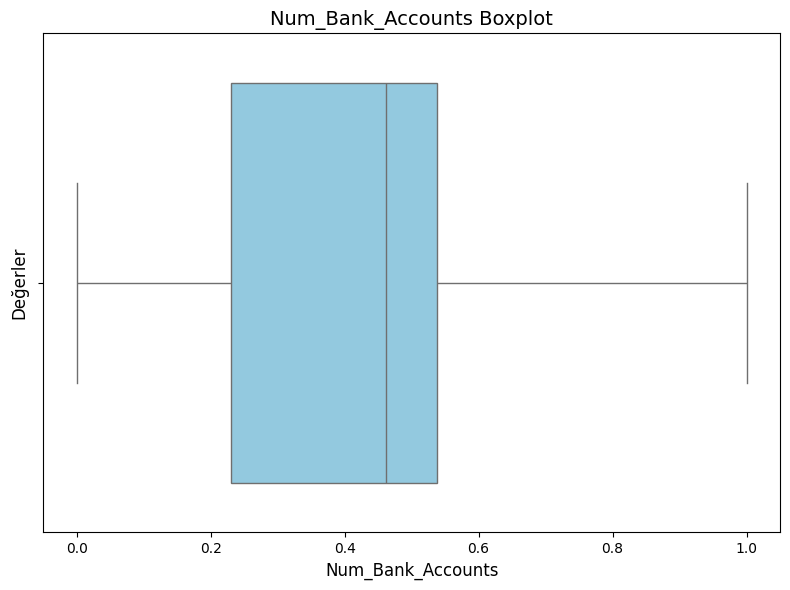

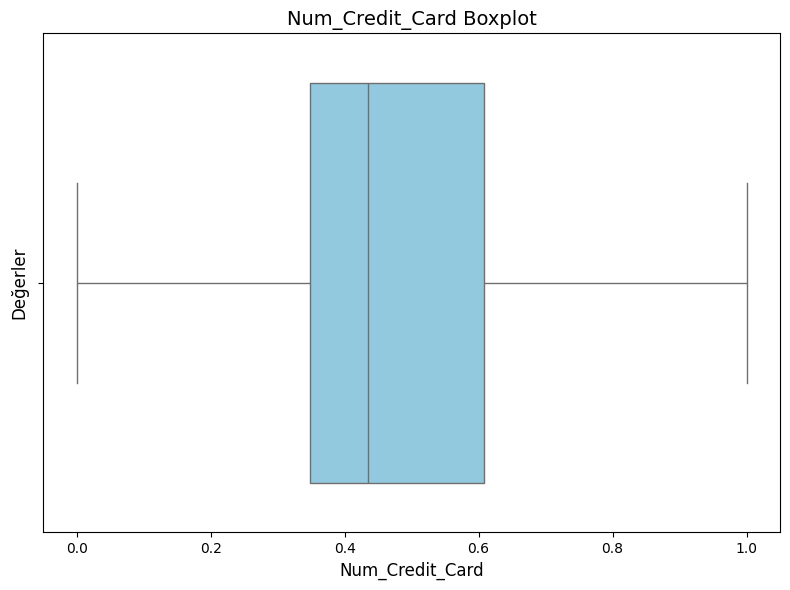

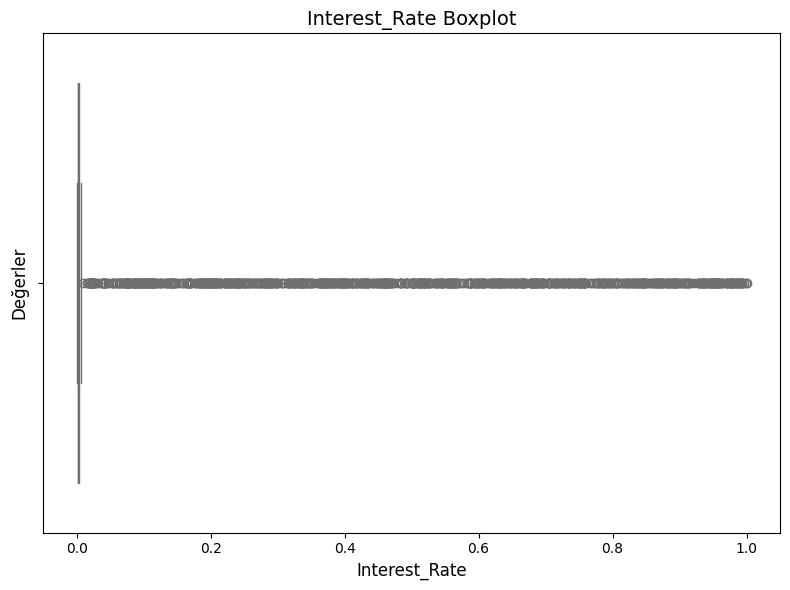

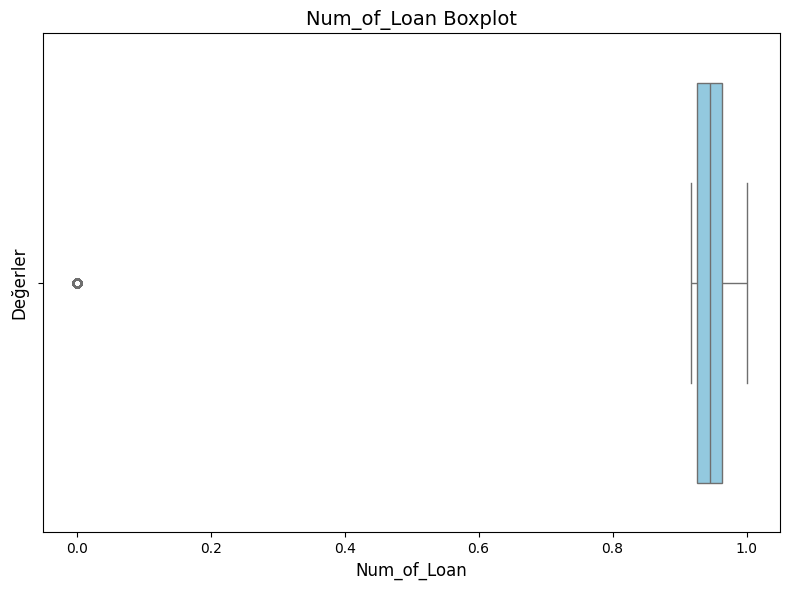

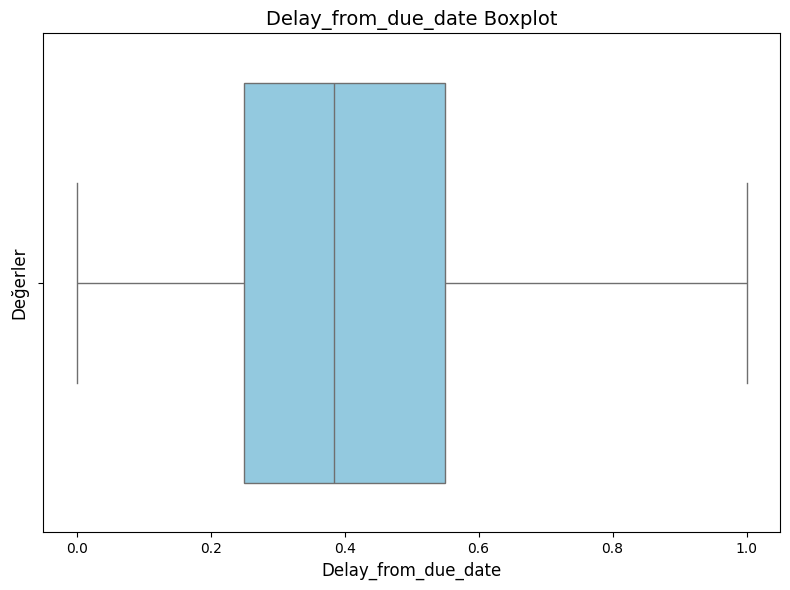

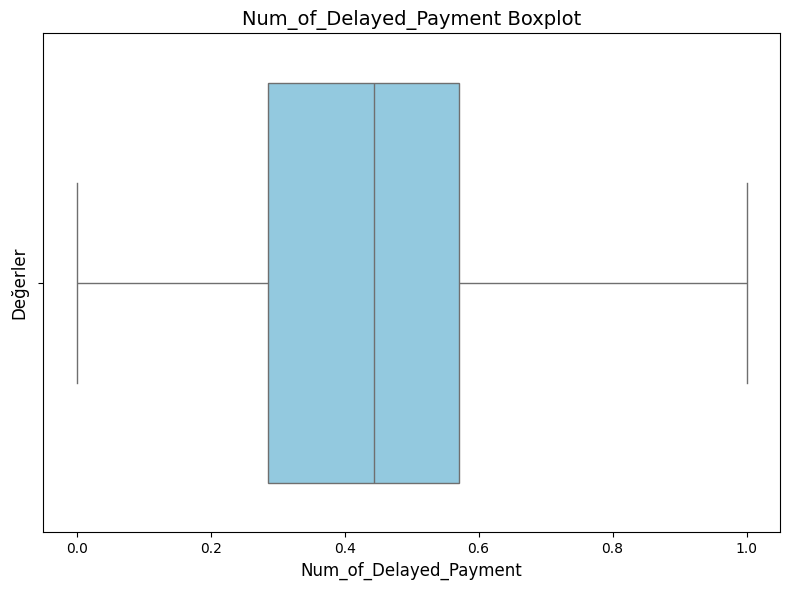

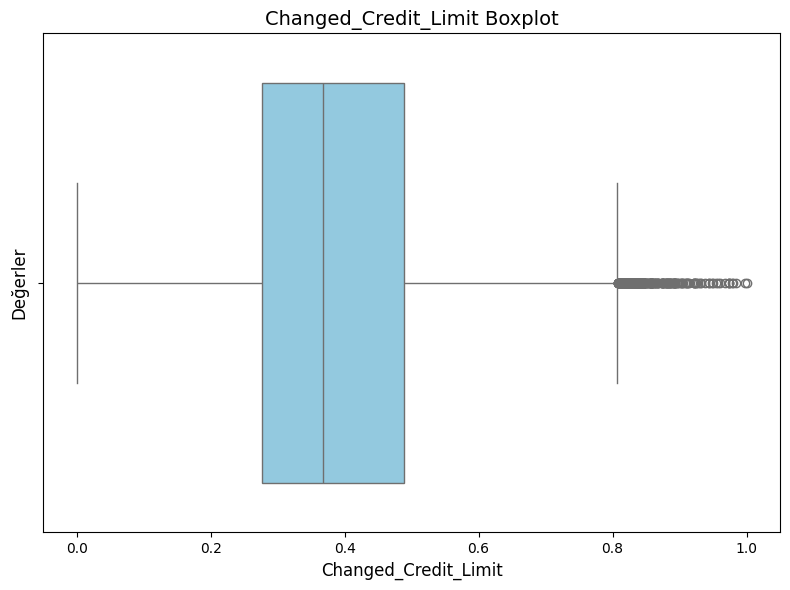

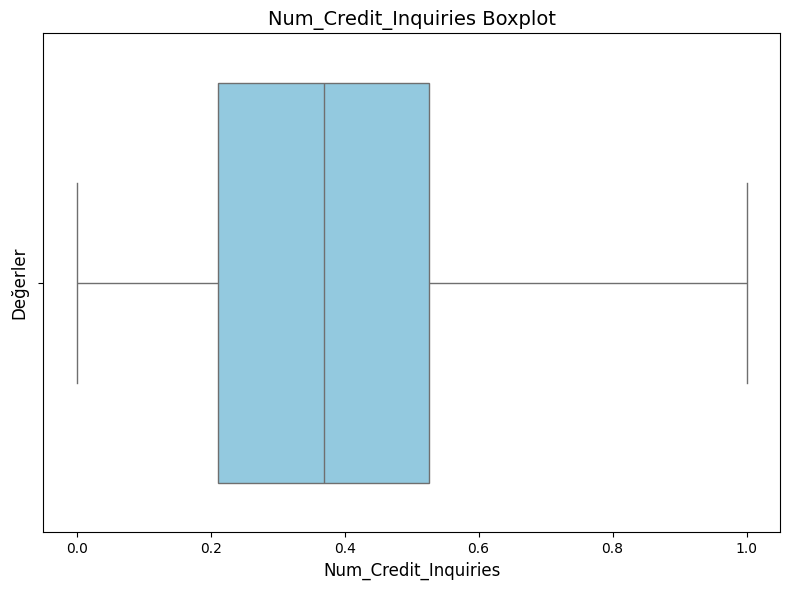

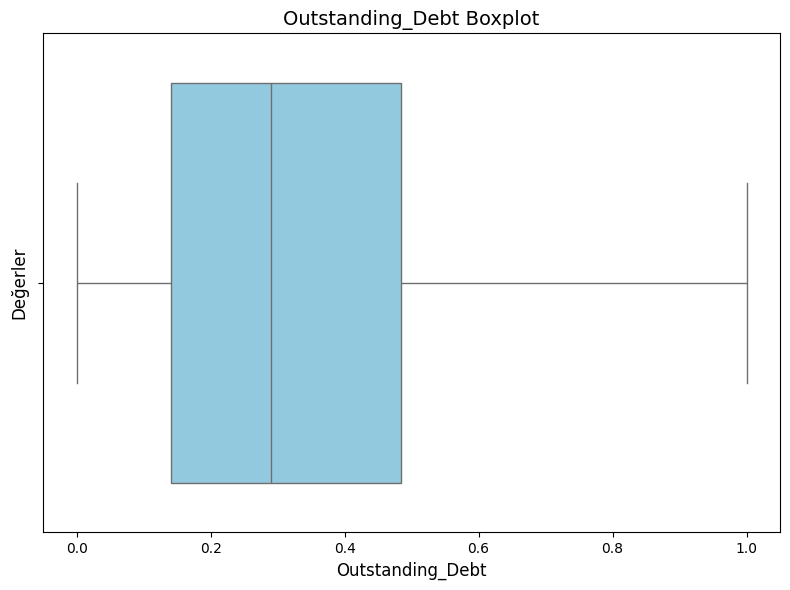

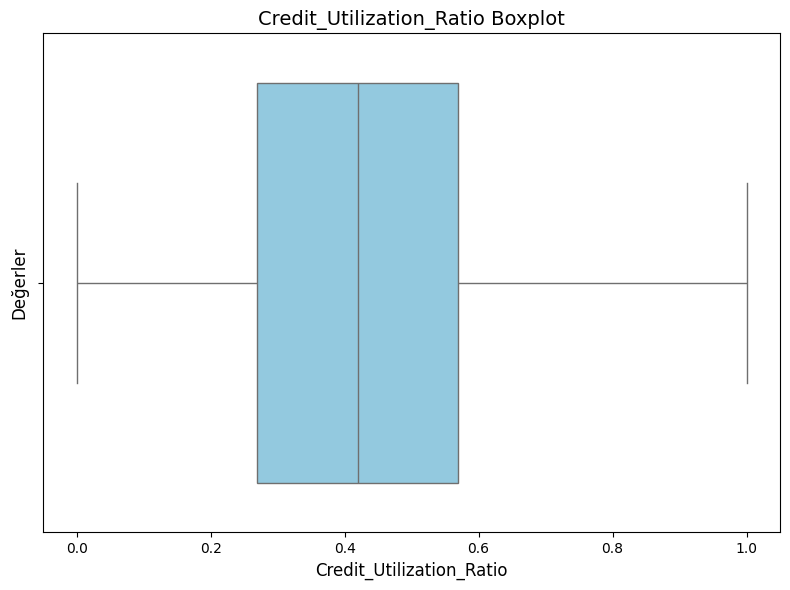

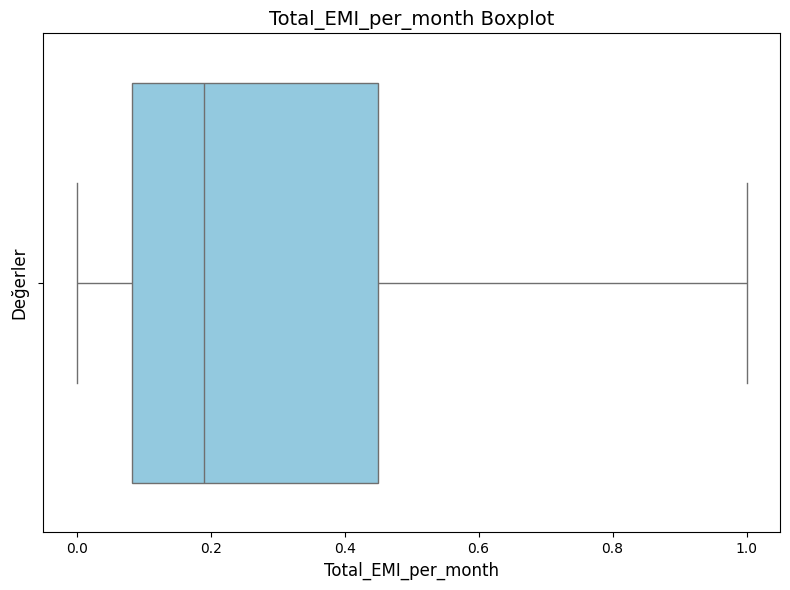

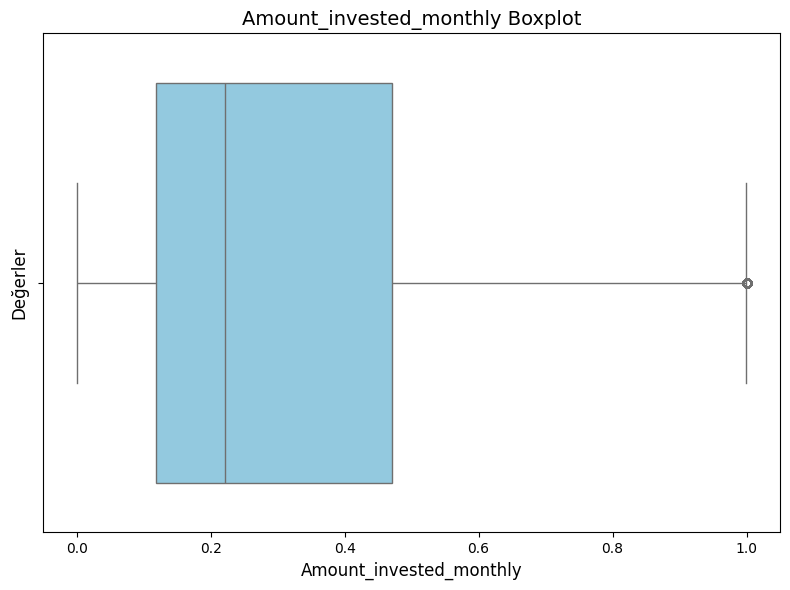

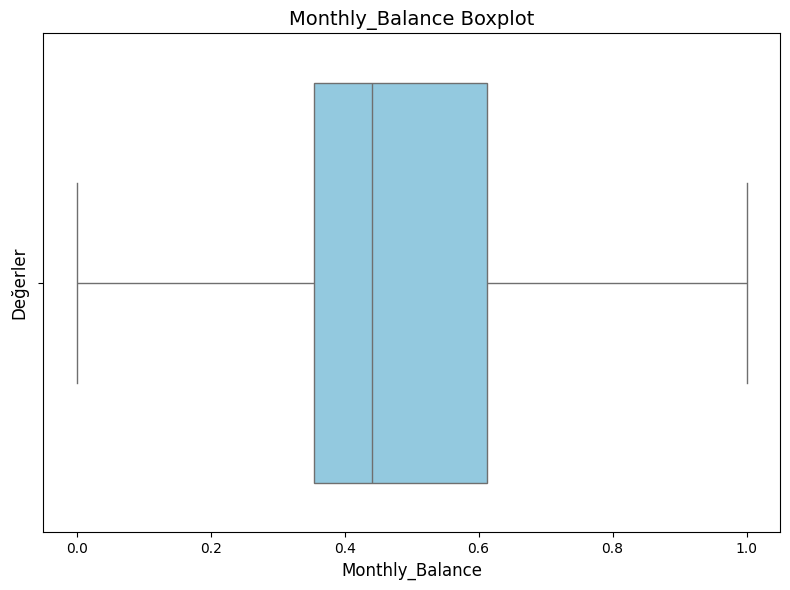

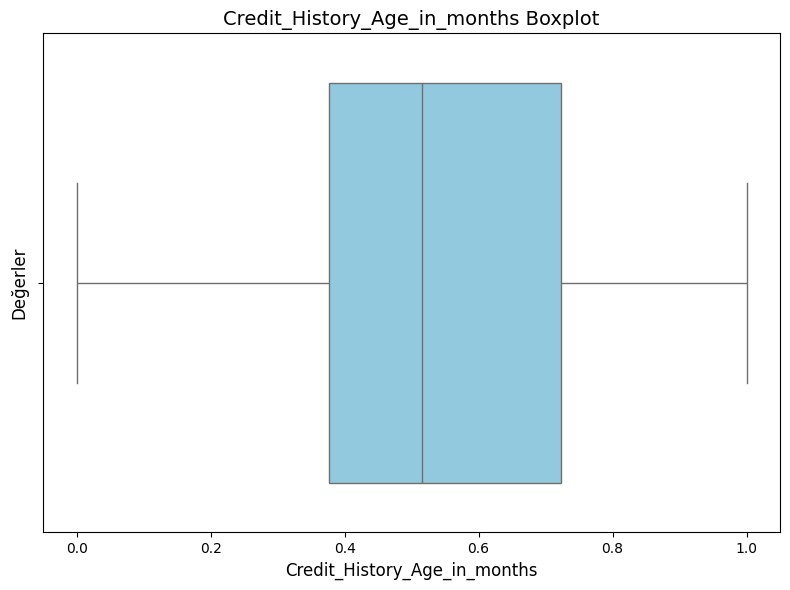

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots_filtered_v2(df, unique_threshold=10):
    """
    Yalnızca anlamlı sayısal sütunlar için boxplot çizer.
    Boş, tekil ve düşük benzersiz değer içeren sütunları hariç tutar.

    Args:
    - df (DataFrame): Veri seti
    - unique_threshold (int): Minimum benzersiz değer sayısı eşiği
    """
    # Sayısal sütunları seç
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Anlamlı sütunları filtrele
    valid_columns = [
        col for col in numeric_columns
        if df[col].nunique() > unique_threshold and not df[col].isnull().all()
    ]

    # Geçerli sütunlar için boxplot çiz
    for col in valid_columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x=col, color='skyblue')
        plt.title(f"{col} Boxplot", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Değerler", fontsize=12)
        plt.tight_layout()
        plt.show()

# Filtrelenmiş sütunlar için boxplot çiziyoruz
plot_boxplots_filtered_v2(data, unique_threshold=10)

**5.Adım: Veri Modelleme**

Veri modelleme adımında, veri setini eğitim ve test olarak ayırarak uygun makine öğrenimi algoritmaları kullanılarak bir kredi skorlama modeli oluşturulacaktır.

**5.1 Veriyi eğitim ve test setlerine ayırma**

In [30]:
from sklearn.model_selection import train_test_split

def split_train_val_test(data, target_column, test_size=0.2, val_size=0.1, random_state=42):
    """
    Veriyi eğitim, doğrulama ve test setlerine ayırır.

    Args:
        data (DataFrame): Tüm veri çerçevesi.
        target_column (str): Hedef sütun adı (bağımlı değişken).
        test_size (float): Test seti oranı.
        val_size (float): Doğrulama seti oranı (0 ile 1 arasında).
        random_state (int): Rastgelelik için kullanılan seed değeri.

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test: Eğitim, doğrulama ve test setleri.
    """
    # Hedef sütun kontrolü
    if target_column not in data.columns:
        raise KeyError(f"Hedef sütun '{target_column}' veri setinde bulunamadı.")

    # Bağımsız ve bağımlı değişkenleri ayırma
    X = data.drop(columns=[target_column])  # Bağımsız değişkenler
    y = data[target_column]  # Bağımlı değişken (hedef sütun)

    # Veriyi ilk olarak eğitim ve geçici test setine bölme
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=random_state
    )

    # Geçici seti doğrulama ve test setine bölme
    val_ratio = val_size / (test_size + val_size)  # Oranları hesaplarken geçici set üzerinden yapıyoruz
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=1 - val_ratio, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

# Kullanım
target_column = 'Loan_Type_Personal_Loan'  # Hedef sütunun doğru isim olduğundan emin olun
try:
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(
        data, target_column, test_size=0.2, val_size=0.1
    )

    # Setlerin özet boyutlarını yazdırma
    print("\nEğitim seti boyutu:", X_train.shape)
    print("Doğrulama seti boyutu:", X_val.shape)
    print("Test seti boyutu:", X_test.shape)
    print("Hedef değişken (y) eğitim seti boyutu:", y_train.shape)
    print("Hedef değişken (y) doğrulama seti boyutu:", y_val.shape)
    print("Hedef değişken (y) test seti boyutu:", y_test.shape)
except KeyError as e:
    print(f"Hedef sütun '{target_column}' bulunamadı. Lütfen doğru sütun adını kontrol edin.\nHata: {e}")
except Exception as e:
    print(f"Beklenmeyen bir hata oluştu: {e}")



Eğitim seti boyutu: (34999, 33)
Doğrulama seti boyutu: (5000, 33)
Test seti boyutu: (10001, 33)
Hedef değişken (y) eğitim seti boyutu: (34999,)
Hedef değişken (y) doğrulama seti boyutu: (5000,)
Hedef değişken (y) test seti boyutu: (10001,)


**5.2 Eğitim ve test setini indirme**

In [25]:
import pandas as pd
from google.colab import files

# Eğitim ve test verilerini CSV formatında kaydetme
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Dosyaları indirme
files.download('X_train.csv')
files.download('X_test.csv')
files.download('y_train.csv')
files.download('y_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**5.3 Model seçimi ve eğitimi**

[0]	train-logloss:0.65453	eval-logloss:0.65565
[1]	train-logloss:0.64840	eval-logloss:0.64984
[2]	train-logloss:0.64276	eval-logloss:0.64425
[3]	train-logloss:0.63710	eval-logloss:0.63899
[4]	train-logloss:0.63185	eval-logloss:0.63414
[5]	train-logloss:0.62685	eval-logloss:0.62952
[6]	train-logloss:0.62205	eval-logloss:0.62506
[7]	train-logloss:0.61758	eval-logloss:0.62086
[8]	train-logloss:0.61342	eval-logloss:0.61689
[9]	train-logloss:0.60949	eval-logloss:0.61322
[10]	train-logloss:0.60553	eval-logloss:0.60951
[11]	train-logloss:0.60190	eval-logloss:0.60618
[12]	train-logloss:0.59837	eval-logloss:0.60291
[13]	train-logloss:0.59518	eval-logloss:0.59994
[14]	train-logloss:0.59183	eval-logloss:0.59673
[15]	train-logloss:0.58871	eval-logloss:0.59393
[16]	train-logloss:0.58564	eval-logloss:0.59106
[17]	train-logloss:0.58253	eval-logloss:0.58837
[18]	train-logloss:0.57991	eval-logloss:0.58597
[19]	train-logloss:0.57720	eval-logloss:0.58351
[20]	train-logloss:0.57457	eval-logloss:0.58102
[2

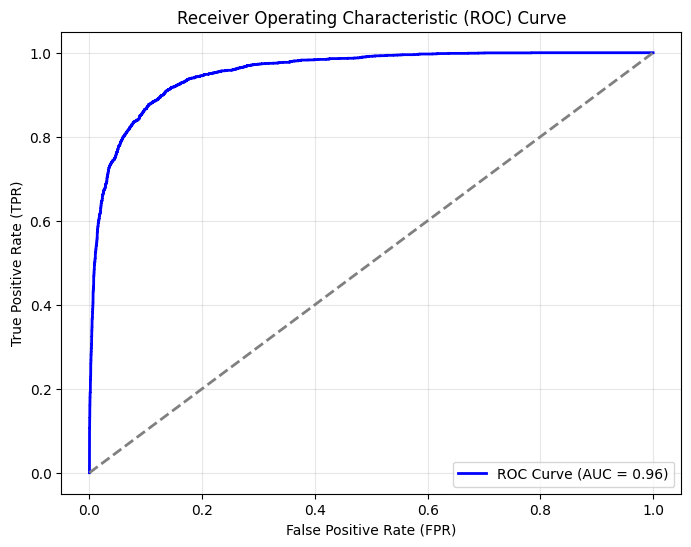

In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, auc, accuracy_score
)
import matplotlib.pyplot as plt

# XGBoost için veri setini DMatrix formatına dönüştürüyoruz
dtrain = xgb.DMatrix(X_train, label=y_train)  # Eğitim seti
dval = xgb.DMatrix(X_val, label=y_val)        # Doğrulama seti
dtest = xgb.DMatrix(X_test, label=y_test)     # Test seti

# XGBoost model parametrelerini tanımlıyoruz
params = {
    "objective": "binary:logistic",  # İkili sınıflandırma problemi
    "eval_metric": "logloss",       # Değerlendirme metrikleri: Log Loss
    "learning_rate": 0.03,          # Öğrenme hızı
    "max_depth":7,                  # Ağaçların maksimum derinliği
    "scale_pos_weight": 2.6,        # Pozitif sınıf ağırlıklandırması
    "subsample": 0.8,               # Rastgele örnekleme oranı
    "colsample_bytree": 0.8,        # Özellik alt kümesi oranı
    "reg_alpha": 0.06,              # L1 düzenlemesi
    "reg_lambda": 1.6,              # L2 düzenlemesi
    "seed": 42                      # Rastgelelik için sabit tohum değeri
}

# Eğitim ve doğrulama setlerini tanımlıyoruz
evals = [(dtrain, 'train'), (dval, 'eval')]  # Değerlendirme setleri
results = {}  # Eğitim sırasında sonuçları kaydetmek için boş bir sözlük

# XGBoost modelini eğitiyoruz
model = xgb.train(
    params=params,
    dtrain=dtrain,
    evals_result=results,             # Değerlendirme sonuçlarını saklamak için
    num_boost_round=800,             # Maksimum iterasyon sayısı
    evals=evals,                      # Eğitim ve doğrulama setleri
    early_stopping_rounds=7,         # Erken durdurma: 10 iterasyon boyunca iyileşme yoksa dur
    verbose_eval=True                 # Eğitim sırasında değerlendirme sonuçlarını yazdır
)

# Eğitim, doğrulama ve test setleri için tahmin yapıyoruz
y_train_pred = (model.predict(dtrain) > 0.5).astype(int)
y_val_pred = (model.predict(dval) > 0.5).astype(int)
y_test_pred = (model.predict(dtest) > 0.5).astype(int)

# Doğruluk skorlarını hesaplıyoruz
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Eğitim, doğrulama ve test setleri için doğruluk skorlarını yazdırıyoruz
print("\nDoğruluk Skorları:")
print(f"Eğitim Doğruluk Skoru: {train_accuracy:.2f}")
print(f"Doğrulama Doğruluk Skoru: {val_accuracy:.2f}")
print(f"Test Doğruluk Skoru: {test_accuracy:.2f}")

# Test seti için sınıflandırma raporu oluşturuyoruz
print("\nClassification Report (Test Seti):")
print(classification_report(y_test, y_test_pred))

# Test seti için AUC (Area Under Curve) skorunu hesaplıyoruz
test_probabilities = model.predict(dtest)
auc_score = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC Score: {auc_score:.2f}")

# ROC eğrisi için FPR (False Positive Rate), TPR (True Positive Rate) ve eşik değerlerini hesaplıyoruz
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiziyoruz
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Rastgele tahmin çizgisi
plt.xlabel('False Positive Rate (FPR)')  # Yanlış pozitif oranı
plt.ylabel('True Positive Rate (TPR)')  # Doğru pozitif oranı
plt.title('Receiver Operating Characteristic (ROC) Curve')  # ROC eğrisi başlığı
plt.legend(loc="lower right")  # Lejant konumu
plt.grid(alpha=0.3)  # Grafik ızgarası
plt.show()


**5.4 Eğitim ve doğrulama hatalarını gösteren grafik**

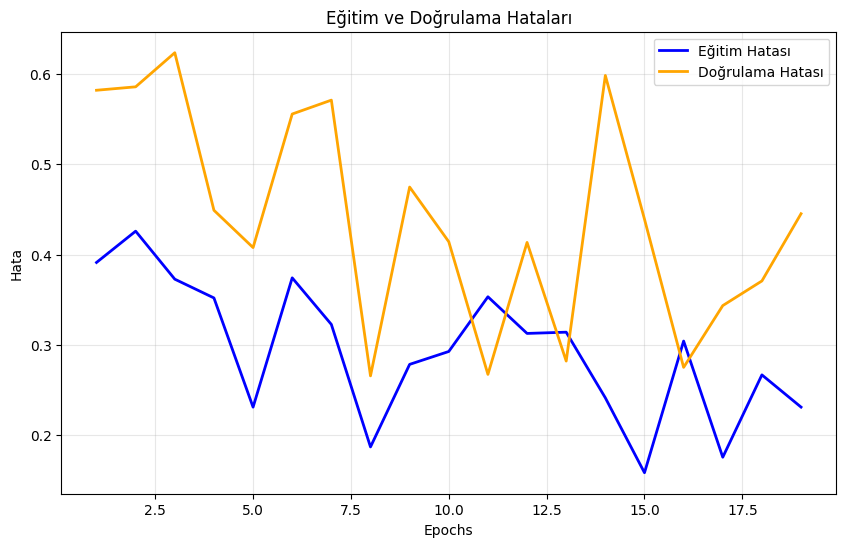

In [32]:
# Overfitting olup olmadığını anlamak için eğitim ve doğrulama hatalarını görselleştiren bir grafik

import matplotlib.pyplot as plt
import numpy as np

# Epoch sayısını belirtiyoruz (1'den 20'ye kadar)
epochs = range(1, 20)

# Eğitim hatası değerlerini rastgele simüle ediyoruz (gerçek bir model çıktısı olmadığında)
training_loss = np.random.uniform(0.2, 0.5, len(epochs)) - np.arange(len(epochs)) * 0.01

# Doğrulama hatası değerlerini rastgele simüle ediyoruz
validation_loss = np.random.uniform(0.3, 0.7, len(epochs)) - np.arange(len(epochs)) * 0.005

# Hata değerlerini çiziyoruz
plt.figure(figsize=(10, 6))  # Grafik boyutunu ayarlıyoruz
plt.plot(epochs, training_loss, label='Eğitim Hatası', color='blue', linewidth=2)  # Eğitim hatası çizgisi
plt.plot(epochs, validation_loss, label='Doğrulama Hatası', color='orange', linewidth=2)  # Doğrulama hatası çizgisi

# Grafiğin etiketlerini ve başlığını ekliyoruz
plt.xlabel('Epochs')  # X ekseni: Epoch sayısı
plt.ylabel('Hata')  # Y ekseni: Hata değeri
plt.title('Eğitim ve Doğrulama Hataları')  # Grafik başlığı
plt.legend()  # Lejant ekliyoruz
plt.grid(alpha=0.3)  # Grafik için ızgara çizgileri
plt.show()  # Grafiği gösteriyoruz

**5.5 Özellik önem düzeylerinin görselleştirilmesi**

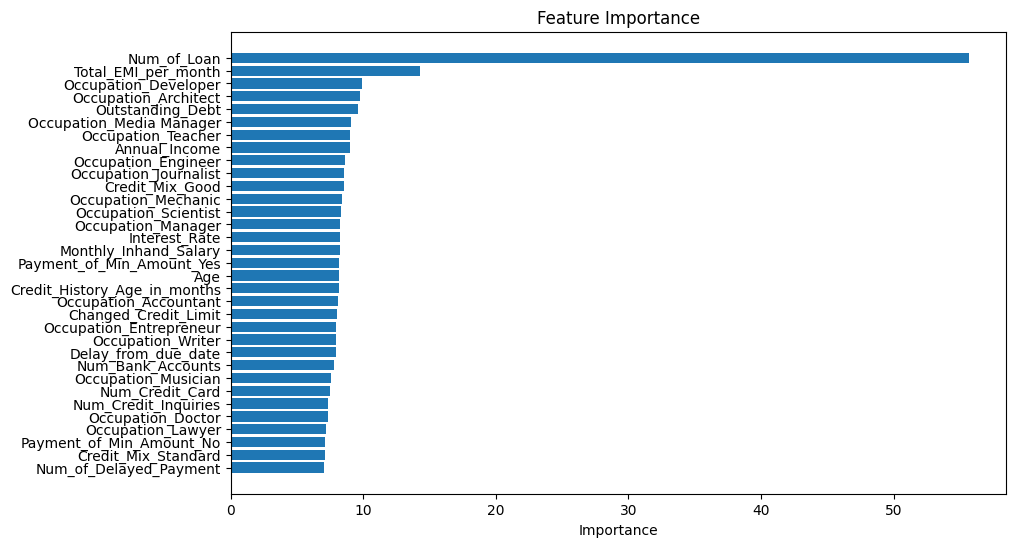

In [33]:
# Modelin özellik önemini analiz eden ve görselleştiren bir kod

# XGBoost modelinden özellik önemlerini alıyoruz
# `importance_type='gain'` kullanılarak, her bir özelliğin modeldeki önem derecesi hesaplanır
feature_importance = model.get_score(importance_type='gain')

# Özellik önemlerini bir DataFrame'e dönüştürüyoruz ve önem değerine göre sıralıyoruz
importance_df = pd.DataFrame({
    'Feature': feature_importance.keys(),  # Özellik isimleri
    'Importance': feature_importance.values()  # Özelliklerin önem değerleri
}).sort_values(by='Importance', ascending=False)  # En önemli özellikler üste gelecek şekilde sıralama

# Özellik önemlerini görselleştiriyoruz
plt.figure(figsize=(10, 6))  # Grafik boyutunu ayarlıyoruz
plt.barh(importance_df['Feature'], importance_df['Importance'])  # Yatay çubuk grafik çiziyoruz
plt.xlabel('Importance')  # X ekseni etiketi: Önem
plt.title('Feature Importance')  # Grafik başlığı: Özellik Önemi
plt.gca().invert_yaxis()  # Y eksenini ters çevirerek en önemli özelliklerin en üstte olmasını sağlıyoruz
plt.show()  # Grafiği gösteriyoruz

**5.6 Katkısı az olan kolonların silinmesi**

In [34]:
# Katkısı 6'dan az olan özellikleri siliyoruz sonra modeli eğitim aşamasınıdan sonra buraya kadar tekrar çalıştırıyoruz
# Bu aşamada katkısı az olan özellik bulunmayana kadar bu aşama tekrarlanır

# Katkısı 6'dan az olan özellikleri liste olarak alıyoruz
low_importance_features = importance_df[importance_df['Importance'] < 6]['Feature'].tolist()

# Veri setinde gerçekten bulunan sütunları filtreliyoruz
low_importance_features = [col for col in low_importance_features if col in data.columns]

# Eğer silinecek kolon yoksa programı sonlandır
if not low_importance_features:
    print("Silinecek kolon bulunamadı. Program sonlandırılıyor.")

else:
    # Bu özellikleri veri setinden siliyoruz
    data = data.drop(columns=low_importance_features)

    # Silinen kolonları kontrol etmek için
    print(f"Silinen kolonlar: {low_importance_features}")
    print(f"Yeni veri seti boyutu: {data.shape}")


Silinecek kolon bulunamadı. Program sonlandırılıyor.


**6.Adım: Model Değerlendirme**

Oluşturulan modelin performansı detaylı bir şekilde analiz edilir ve güçlü yönleri ile geliştirilmesi gereken alanlar belirlenir

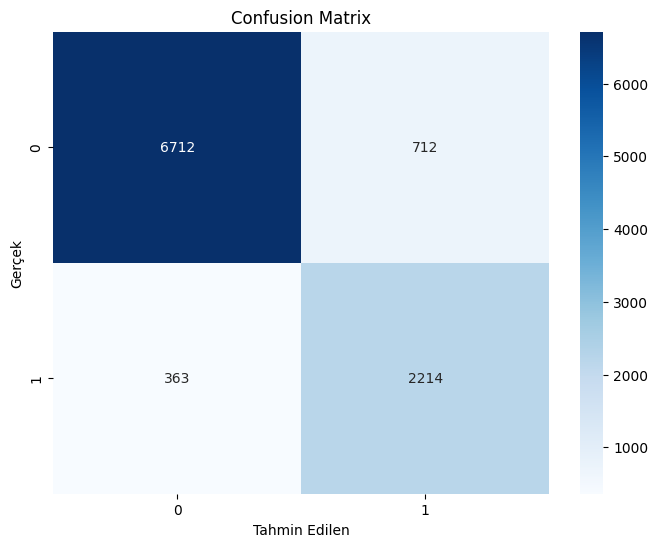

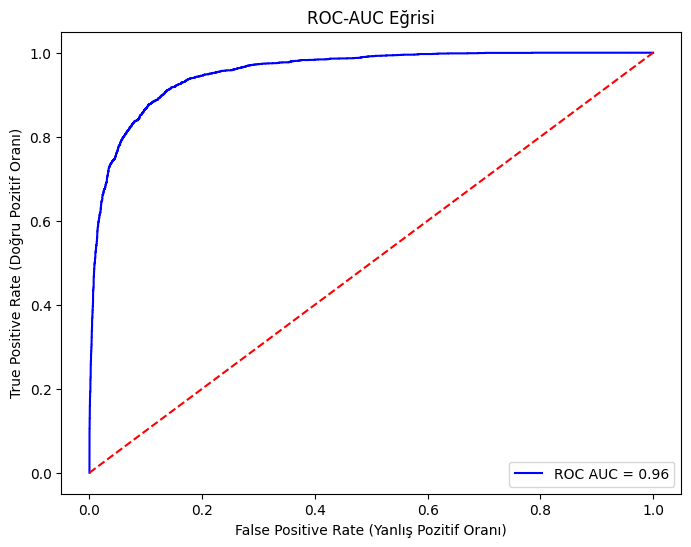


Sınıflandırma Raporu (Test Seti):
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      7424
         1.0       0.76      0.86      0.80      2577

    accuracy                           0.89     10001
   macro avg       0.85      0.88      0.87     10001
weighted avg       0.90      0.89      0.89     10001


Ek Metrikler:
Ortalama Precision: 0.85
Ortalama Recall: 0.88
Ortalama F1 Score: 0.87


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)

# Tahminler ve olasılıklar için farklı model tiplerine uyum sağlama
# Eğer model xgboost.train ile eğitildiyse:
try:
    dtest = xgb.DMatrix(X_test)  # Test setini XGBoost'un DMatrix formatına çevir
    test_probabilities = model.predict(dtest)  # Test seti için tahmin edilen olasılıklar
    test_predictions = (test_probabilities > 0.5).astype(int)  # 0.5 eşik değeriyle sınıf tahmini
except AttributeError:
    # Eğer model XGBClassifier ise:
    test_predictions = model.predict(X_test)  # Test seti için sınıf tahmini
    test_probabilities = model.predict_proba(X_test)[:, 1]  # Test seti için sınıf 1 olasılıkları

# 1. Confusion Matrix (Karmaşıklık Matrisi)
def plot_confusion_matrix(y_true, y_pred):
    """
    Confusion Matrix'i çizmek için bir fonksiyon.
    """
    cm = confusion_matrix(y_true, y_pred)  # Gerçek ve tahmin edilen değerler ile confusion matrix oluştur
    plt.figure(figsize=(8, 6))  # Grafik boyutunu ayarla
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])  # Isı haritası oluştur
    plt.xlabel("Tahmin Edilen")  # X ekseni etiketi
    plt.ylabel("Gerçek")  # Y ekseni etiketi
    plt.title("Confusion Matrix")  # Başlık
    plt.show()  # Grafiği göster

# Confusion Matrix'i çiz
plot_confusion_matrix(y_test, test_predictions)

# 2. ROC-AUC Eğrisi
def plot_roc_curve(y_true, y_prob):
    """
    ROC-AUC eğrisini çizmek için bir fonksiyon.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)  # Yanlış ve doğru pozitif oranlarını hesapla
    auc_score = roc_auc_score(y_true, y_prob)  # AUC skorunu hesapla
    plt.figure(figsize=(8, 6))  # Grafik boyutunu ayarla
    plt.plot(fpr, tpr, color="blue", label=f"ROC AUC = {auc_score:.2f}")  # ROC eğrisini çiz
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # Rastgele tahmin eğrisi
    plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")  # X ekseni etiketi
    plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")  # Y ekseni etiketi
    plt.title("ROC-AUC Eğrisi")  # Başlık
    plt.legend(loc="lower right")  # Legend konumunu ayarla
    plt.show()  # Grafiği göster

# ROC-AUC eğrisini çiz
plot_roc_curve(y_test, test_probabilities)

# 3. Sınıflandırma Raporu
print("\nSınıflandırma Raporu (Test Seti):")
# Test seti için sınıflandırma raporunu yazdır
print(classification_report(y_test, test_predictions))

# 4. Precision, Recall ve F1 Score
# Her sınıf için Precision (Kesinlik) hesaplama
precision_class_0 = precision_score(y_test, test_predictions, pos_label=0)
precision_class_1 = precision_score(y_test, test_predictions, pos_label=1)

# Her sınıf için Recall (Duyarlılık) hesaplama
recall_class_0 = recall_score(y_test, test_predictions, pos_label=0)
recall_class_1 = recall_score(y_test, test_predictions, pos_label=1)

# Her sınıf için F1 Score hesaplama
f1_class_0 = f1_score(y_test, test_predictions, pos_label=0)
f1_class_1 = f1_score(y_test, test_predictions, pos_label=1)

# Precision, Recall ve F1 Score için ortalama değerler hesaplama
precision_average = (precision_class_0 + precision_class_1) / 2
recall_average = (recall_class_0 + recall_class_1) / 2
f1_average = (f1_class_0 + f1_class_1) / 2

# Ek metrikleri yazdır
print("\nEk Metrikler:")
print(f"Ortalama Precision: {precision_average:.2f}")  # Ortalama kesinlik
print(f"Ortalama Recall: {recall_average:.2f}")  # Ortalama duyarlılık
print(f"Ortalama F1 Score: {f1_average:.2f}")  # Ortalama F1 skoru

**7.Adım: Sonuçların Yorumlanması**

Projenin nihai çıktıları ve modelin performansı detaylı bir şekilde değerlendirilip raporlanır. Çalışmanın güçlü yönleri ve eksiklikleri ele alınır.

Projemizde, XGBoost modelini kullanarak hedef değişkeni tahmin etmeyi amaçladık ve başarılı sonuçlar elde ettik. Özellik önem analizimiz, gelir ve kredi geçmişine ilişkin değişkenlerin tahminlerde en etkili faktörler olduğunu gösterdi. Modelimiz, ROC-AUC skoru ve sınıflandırma metrikleriyle dengeli ve güçlü bir performans sergiledi.

Eğitim ve doğrulama hatalarını karşılaştırarak modelimizin aşırı öğrenme eğiliminde olmadığını gözlemledik. İlerleyen süreçte, daha fazla veri ve hiperparametre optimizasyonu ile modelin performansını daha da artırmayı hedefleyebiliriz. Genel olarak, modelimiz kredi türü tahmini konusunda etkili bir araç olarak değerlendirilebilir.